In [12]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)

from scipy.integrate import quad

from crc_scripts.io.gizmo import *
from crc_scripts.observations import dust_obs as obs
from crc_scripts.observations.obs_data import Observational_Data
from crc_scripts.utils.math_utils import *
import crc_scripts.utils.data_calc_utils as calc
from crc_scripts.figure import Figure,Projection
from crc_scripts.analysis.data_reduction import Buffer
import crc_scripts.utils.plot_utils as plt_set
import matplotlib.lines as mlines

import crc_scripts.analytical_models.grain_size_evo as gse

# First setup directory for all the plots
plot_dir = os.path.join(os.environ['BIGRED'],'dust_size_evo/')
os.makedirs(plot_dir, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Code Testing
Testing to make sure the size evolution routines are working.

### Testing SNe Destruction

In [13]:
# Name prefix for all saved images. Useful if you run this for multiple sims.
prefix=['size_evolution_dev']

main_dirc = '/N/u/cchoban/BigRed200/'
# Names of simulation directories
sim_names = np.array(['size_evolution_dev'])

# Snapshot to check
snap_nums = [0,1]

# Main sim directories and their snap and halo directories
# Default sim layout is assumed
# Note you need to specify the dtype or else you get numpy strings which annoying to deal with
main_dirs = np.array([main_dirc+name+'/' for name in sim_names], dtype=object)
snap_dirs = np.array([main_dirc+name+'/output/' for name in sim_names], dtype=object)
hdirs = np.array([main_dirc+name+'/halo/ahf/output/' for name in sim_names], dtype=object)
# We only look at the main halos
halo_histories = np.array([main_dirc+name+'/halo/ahf/history/halo_main.dat' for name in sim_names], dtype=object)

In [14]:
snaps = [[]]*len(snap_dirs)

for i,snap_dir in enumerate(snap_dirs):
    print("Snap Dirc: ",snap_dir)
    name = sim_names[i]
    hdir = hdirs[i]

    for j, snap_num in enumerate(snap_nums):
        print("Snap Num:",snap_num)
        sp = load_snap(snap_dir, snap_num, cosmological=0)
        snaps[i] += [sp]


Snap Dirc:  /N/u/cchoban/BigRed200/size_evolution_dev/output/
Snap Num: 0
/N/u/cchoban/BigRed200/size_evolution_dev/output/snapdir_000/snapshot_000.0.hdf5
Snapshot /N/u/cchoban/BigRed200/size_evolution_dev/output//snapshot_000.hdf5 doesn't exist.
Snap Num: 1
/N/u/cchoban/BigRed200/size_evolution_dev/output/snapdir_001/snapshot_001.0.hdf5
Snapshot /N/u/cchoban/BigRed200/size_evolution_dev/output//snapshot_001.hdf5 doesn't exist.


AttributeError: 'Snapshot' object has no attribute 'part'

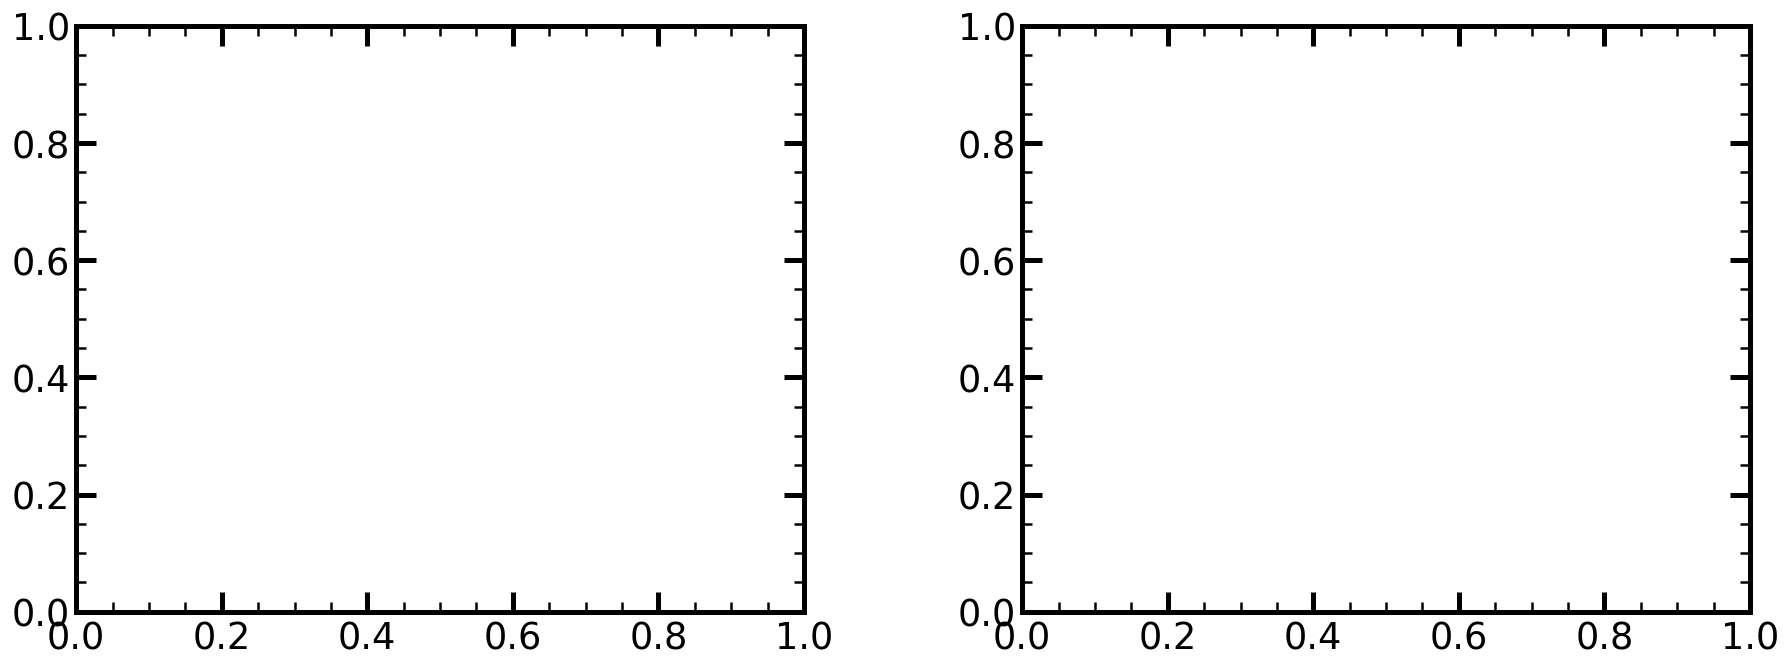

In [15]:
for i,sim_snaps in enumerate(snaps):

    foutname = plot_dir+sim_names[i] + '_SNeDest0_FIRE2_test.pdf'
    num_snaps = len(sim_snaps)
    fig = Figure(2,ncols=2)
    colors = config.LINE_COLORS[:num_snaps]
    linestyles = config.LINE_STYLES[:num_snaps]
    linewidth = 2*config.BASE_LINEWIDTH
    for j,sp in enumerate(sim_snaps):
        G=sp.loadpart(0)
        time = sp.time*1E3
        spec_ind = 0
        mask = np.argsort(G.get_property('dust_Z')[:,0])
        if j != 0:
            mask = (G.get_property('dust_Z')[:,0]< 0.7*np.max(G.get_property('dust_Z')[:,0])) & (G.get_property('dust_Z')[:,0] > 0.4*np.max(G.get_property('dust_Z')[:,0]))
        #mask = calc.get_particle_mask(0, sp, mask_criteria='cold')

        dnda_bin_points, dnda_means, dnda_stds  =  gse.get_grain_size_dist(sp, spec_ind, mask=mask, mass=False,points_per_bin=10)
        dmda_bin_points, dmda_means, dmda_stds =  gse.get_grain_size_dist(sp, spec_ind, mask=mask, mass=True,points_per_bin=10)
        

        print(np.mean((G.get_property('M_gas')[mask]*G.get_property('dust_spec')[mask,spec_ind])))

        if j == 0:
            fig.set_axis(0, 'grain_size', 'dn/da',y_lim=[np.power(10,-0.5)*np.min(dnda_means),np.power(10,0.5)*np.max(dnda_means)])
            fig.set_axis(1, 'grain_size', 'dm/da',y_lim=[np.power(10,-0.5)*np.min(dmda_means),np.power(10,0.5)*np.max(dmda_means)])

        fig.plot_line_data(0,dnda_bin_points,dnda_means, color=colors[j],linestyle=linestyles[j],label="t = %.0f Myr"%snap_nums[j])
        fig.plot_shaded_region(0,dnda_bin_points,dnda_stds[:,0],dnda_stds[:,1], color=colors[j])
        fig.plot_line_data(1,dmda_bin_points,dmda_means, color=colors[j],linestyle=linestyles[j])
        fig.plot_shaded_region(1,dmda_bin_points,dmda_stds[:,0],dmda_stds[:,1], color=colors[j])

    # Add a comparison to the MRN size distribution
    # C_norm = 1E3/np.power(dnda_bin_points[0],-3.5);
    # MRN_dist = C_norm * np.power(dnda_bin_points,-3.5)
    # fig.plot_line_data(0,dnda_bin_points,MRN_dist, color='xkcd:grey',linestyle=linestyles[1], label='MRN')

    # C_norm = 1E10/np.power(dnda_bin_points[0],0.5);
    # MRN_dist = C_norm * np.power(dnda_bin_points,0.5)
    # fig.plot_line_data(1,dnda_bin_points,MRN_dist, color='xkcd:grey',linestyle=linestyles[1], label='MRN')

    fig.set_all_legends()
    fig.save(foutname)

### Testing SNe Destruction

In [ ]:
# Name prefix for all saved images. Useful if you run this for multiple sims.
prefix=['size_evolution_dev']

main_dirc = '/N/u/cchoban/BigRed200/'
# Names of simulation directories
sim_names = np.array(['size_evolution_dev'])

# Snapshot to check
snap_nums = [5,10]

# Main sim directories and their snap and halo directories
# Default sim layout is assumed
# Note you need to specify the dtype or else you get numpy strings which annoying to deal with
main_dirs = np.array([main_dirc+name+'/' for name in sim_names], dtype=object)
snap_dirs = np.array([main_dirc+name+'/FIRE2_SNeDust_output/' for name in sim_names], dtype=object)
hdirs = np.array([main_dirc+name+'/halo/ahf/output/' for name in sim_names], dtype=object)
# We only look at the main halos
halo_histories = np.array([main_dirc+name+'/halo/ahf/history/halo_main.dat' for name in sim_names], dtype=object)

In [ ]:
snaps = [[]]*len(snap_dirs)

for i,snap_dir in enumerate(snap_dirs):
    print("Snap Dirc: ",snap_dir)
    name = sim_names[i]
    hdir = hdirs[i]

    for j, snap_num in enumerate(snap_nums):
        print("Snap Num:",snap_num)
        sp = load_snap(snap_dir, snap_num, cosmological=0)
        snaps[i] += [sp]


Snap Dirc:  /N/u/cchoban/BigRed200/size_evolution_dev/FIRE2_SNeDust_output/
Snap Num: 5
This snap has grain size bins!
Snap Num: 10
This snap has grain size bins!


[437500 437500 250000 125000      0      1]
0.0008412053
0.0007292468
2.7887592
0.57022357


/geode2/home/u020/cchoban/BigRed200/codes/crc_scripts/src/crc_scripts/utils/plot_utils.py:332: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axis.set_ylim(y_lim)


[437338 437500 250000 125000    162      1]
[0.         1.4062496  1.5624994  2.96875    1.4062496  1.7187502
 0.3124997  0.3124997  0.3124997  2.3046873  0.93750006 1.8750001
 1.2499998  0.15624985 0.3124997  0.6249994  0.3124997  0.3124997
 1.8750001  2.2265623  1.9140625  2.3437495  1.7187502  2.1874998
 2.03125    3.1249998  2.03125    2.1874998  2.8124998  0.93750006
 0.46874955 1.8750001  2.03125    1.5624994  1.5624994  2.03125
 0.46874955 0.46874955 1.7187502  0.93750006 0.3124997  2.3437495
 2.6562498  1.8750001  2.3437495  1.4062496  1.6406244  0.6249994
 0.6249994  0.         0.46874955 0.93750006 1.5624994  0.6249994
 1.3281246  1.2499998  3.1249998  2.3437495  2.03125    0.15624985
 0.6249994  1.5624994  2.1874998  1.0937499  1.4062496  0.7812502
 1.3671871  0.6249994  2.8124998  1.7187502  1.4062496  3.2812498
 0.74218774 0.6249994  2.03125    1.5624994  0.         0.
 2.8124998  2.8124998  4.3749995  1.2499998  1.8750001  0.93750006
 1.0937499  0.93750006 1.4062496  1.64

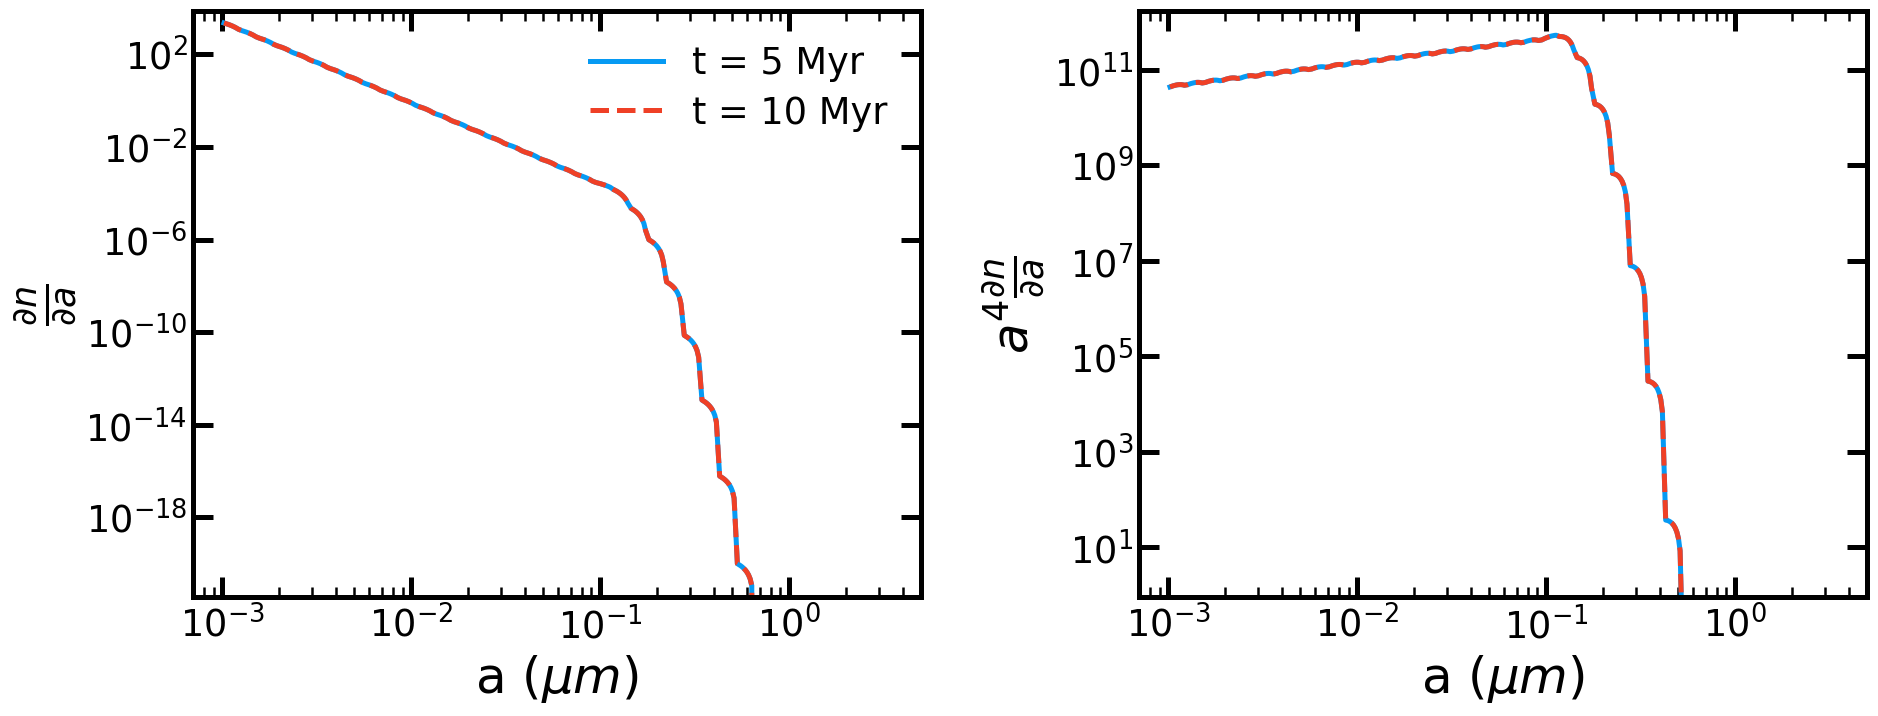

In [ ]:
for i,sim_snaps in enumerate(snaps):

    foutname = plot_dir+sim_names[i] + '_SNeDest0_FIRE2_test.pdf'
    num_snaps = len(sim_snaps)
    fig = Figure(2,ncols=2)
    colors = config.LINE_COLORS[:num_snaps]
    linestyles = config.LINE_STYLES[:num_snaps]
    linewidth = 2*config.BASE_LINEWIDTH
    for j,sp in enumerate(sim_snaps):
        G=sp.loadpart(0)
        S=sp.loadpart(3)
        new_S=sp.loadpart(4)
        print(sp.npart)
        if (sp.npart[4] > 0):
            print(new_S.get_property('age')*1E3)
        time = sp.time*1E3
        spec_ind = 0
        mask = G.get_property('dust_spec')[:,spec_ind]>0
        #mask = calc.get_particle_mask(0, sp, mask_criteria='cold')

        dnda_bin_points, dnda_means, dnda_stds  =  gse.get_grain_size_dist(sp, spec_ind, mask=mask, mass=False,points_per_bin=10)
        dmda_bin_points, dmda_means, dmda_stds =  gse.get_grain_size_dist(sp, spec_ind, mask=mask, mass=True,points_per_bin=10)
        
        age1_mask = (S.get_property('age')<35E-3) & (S.get_property('age')>5E-3)
        age2_mask = (S.get_property('age')<40E-3)
        print(np.sum(G.get_property('M_dust')) / np.sum(S.get_property('M')[age1_mask]))
        print(np.sum(G.get_property('M_dust')) / np.sum(S.get_property('M')[age2_mask]))
        print(np.sum(G.get_property('M_sil'))/np.sum(G.get_property('M_carb')))
        print(np.sum(G.get_property('M_iron'))/np.sum(G.get_property('M_carb')))

        if j == 0:
            fig.set_axis(0, 'grain_size', 'dn/da',y_lim=[np.power(10,-0.5)*np.min(dnda_means[dnda_means>0]),np.power(10,0.5)*np.max(dnda_means)])
            fig.set_axis(1, 'grain_size', 'dm/da',y_lim=[np.power(10,-0.5)*np.min(dmda_means),np.power(10,0.5)*np.max(dmda_means)])

        fig.plot_line_data(0,dnda_bin_points,dnda_means, color=colors[j],linestyle=linestyles[j],label="t = %.0f Myr"%snap_nums[j])
        fig.plot_shaded_region(0,dnda_bin_points,dnda_stds[:,0],dnda_stds[:,1], color=colors[j])
        fig.plot_line_data(1,dmda_bin_points,dmda_means, color=colors[j],linestyle=linestyles[j])
        fig.plot_shaded_region(1,dmda_bin_points,dmda_stds[:,0],dmda_stds[:,1], color=colors[j])

    # Add a comparison to the MRN size distribution
    # C_norm = 1E3/np.power(dnda_bin_points[0],-3.5);
    # MRN_dist = C_norm * np.power(dnda_bin_points,-3.5)
    # fig.plot_line_data(0,dnda_bin_points,MRN_dist, color='xkcd:grey',linestyle=linestyles[1], label='MRN')

    # C_norm = 1E10/np.power(dnda_bin_points[0],0.5);
    # MRN_dist = C_norm * np.power(dnda_bin_points,0.5)
    # fig.plot_line_data(1,dnda_bin_points,MRN_dist, color='xkcd:grey',linestyle=linestyles[1], label='MRN')

    fig.set_all_legends()
    fig.save(foutname)

### Testing Gas-Dust Accretion

In [ ]:
# Name prefix for all saved images. Useful if you run this for multiple sims.
prefix=['size_evolution_dev']

main_dirc = '/N/u/cchoban/BigRed200/'
# Names of simulation directories
sim_names = np.array(['size_evolution_dev'])

# Snapshot to check
snap_nums = [0,2,4,6]

# Main sim directories and their snap and halo directories
# Default sim layout is assumed
# Note you need to specify the dtype or else you get numpy strings which annoying to deal with
main_dirs = np.array([main_dirc+name+'/' for name in sim_names], dtype=object)
snap_dirs = np.array([main_dirc+name+'/FIRE3_accretion_output/' for name in sim_names], dtype=object)
hdirs = np.array([main_dirc+name+'/halo/ahf/output/' for name in sim_names], dtype=object)
# We only look at the main halos
halo_histories = np.array([main_dirc+name+'/halo/ahf/history/halo_main.dat' for name in sim_names], dtype=object)

In [ ]:
snaps = [[]]*len(snap_dirs)

for i,snap_dir in enumerate(snap_dirs):
    print("Snap Dirc: ",snap_dir)
    name = sim_names[i]
    hdir = hdirs[i]

    for j, snap_num in enumerate(snap_nums):
        print("Snap Num:",snap_num)
        sp = load_snap(snap_dir, snap_num, cosmological=0)
        snaps[i] += [sp]


Snap Dirc:  /N/u/cchoban/BigRed200/size_evolution_dev/output/
Snap Num: 0
This snap has grain size bins!
Snap Num: 2
This snap has grain size bins!
Snap Num: 4
This snap has grain size bins!
Snap Num: 6
This snap has grain size bins!


0.0
104.33406
97.546455


IndexError: list index out of range

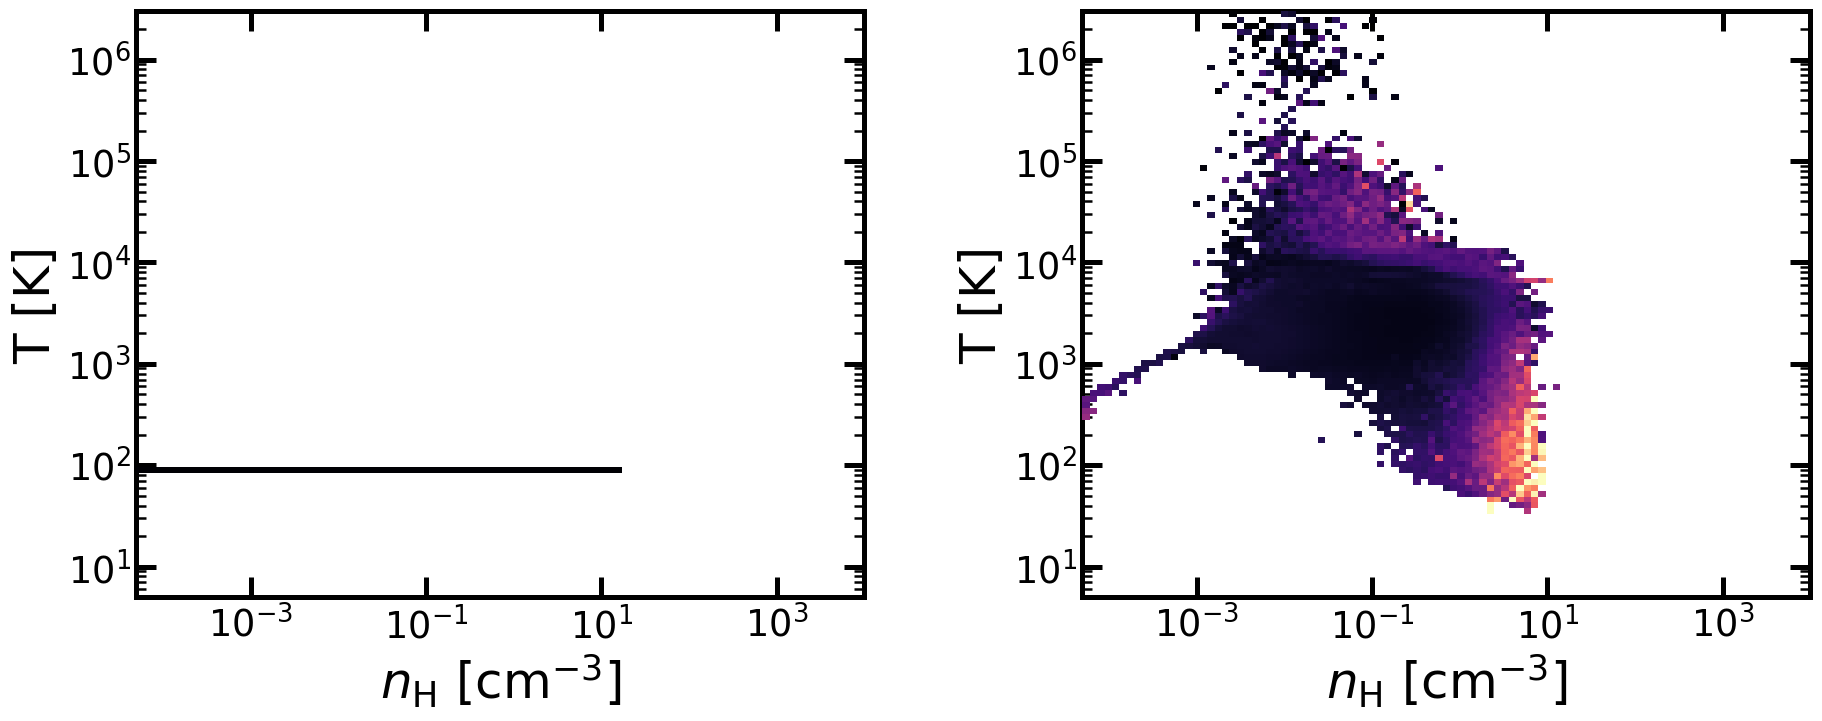

In [ ]:
for i,sim_snaps in enumerate(snaps):

    foutname = plot_dir+sim_names[i] + '_M_num_hist.pdf'
    num_snaps = len(sim_snaps)
    fig = Figure(num_snaps,ncols=2)
    colors = config.LINE_COLORS[:num_snaps]
    linestyles = config.LINE_STYLES[:num_snaps]
    linewidth = 2*config.BASE_LINEWIDTH
    for j,sp in enumerate(sim_snaps):
        G=sp.loadpart(0)
        print(np.max(G.get_property('mach_number')))

        nH_lims = [5E-5,1E4]
        T_lims = [5,3E6]
        bin_nums = 100
        ret = calc.calc_phase_hist_data('mach_number', sp, bin_nums=bin_nums, nH_lims=nH_lims, T_lims=T_lims)
        X, Y = np.meshgrid(ret.x_edge, ret.y_edge)
        fig.set_axis(j, 'nH', 'T')
        fig.plot_2Dhistogram(j, 'mach_number', X, Y, ret.statistic.T, cmap='magma', z_lim=[0,20], z_log=False, label=None, rescale_font=1)
    fig.add_colorbar(j, 'mach_number')
    fig.save(foutname)

    foutname = plot_dir+sim_names[i] + '_M_vs_nH.pdf'
    num_snaps = len(sim_snaps)
    fig = Figure(2,ncols=2)
    colors = config.LINE_COLORS[:num_snaps]
    linestyles = config.LINE_STYLES[:num_snaps]
    linewidth = 2*config.BASE_LINEWIDTH
    for j,sp in enumerate(sim_snaps):

        nH_lims = [5E-5,1E4]
        T_lims = [5,3E6]
        bin_nums = 100
        bin_vals, mean_vals, std_vals = calc.calc_binned_property_vs_property('mach_number' ,'nH', sp, prop_lims=nH_lims)
        fig.set_axis(j, 'nH', 'mach_number')
        fig.plot_line_data(j,bin_vals,mean_vals, y_std=std_vals)
    fig.save(foutname)   

snapshot time 0.0
init depletion 0.5
init spec mass 25529100.0
Change in grains assuming no limit
Old and new N grains 12649110.240673516 12649110.240673516
Old and new M grains 8.112658055818217 8.112658055818217
Change in number: 1.0000000000000002
Change in mass: 1.0000000000000002
change in spec mass 1.0
change in total N grains 1.0
snapshot time 0.002
Change in grains assuming no limit
Old and new N grains 12649110.240673516 12649110.240673516
Old and new M grains 8.112658055818217 11.135458353187941
Change in number: 0.999999999841331
Change in mass: 1.3715635567750049
change in spec mass 1.3243172
change in total N grains 1.0489935668865775
snapshot time 0.004
Change in grains assuming no limit
Old and new N grains 12649110.240673516 12649110.240673518
Old and new M grains 8.112658055818217 18.82082497556992
Change in number: 0.9999999996815454
Change in mass: 2.317840887674161
Mass of grains after update will exceed available mass
Change in grains factoring in depeltion fractio

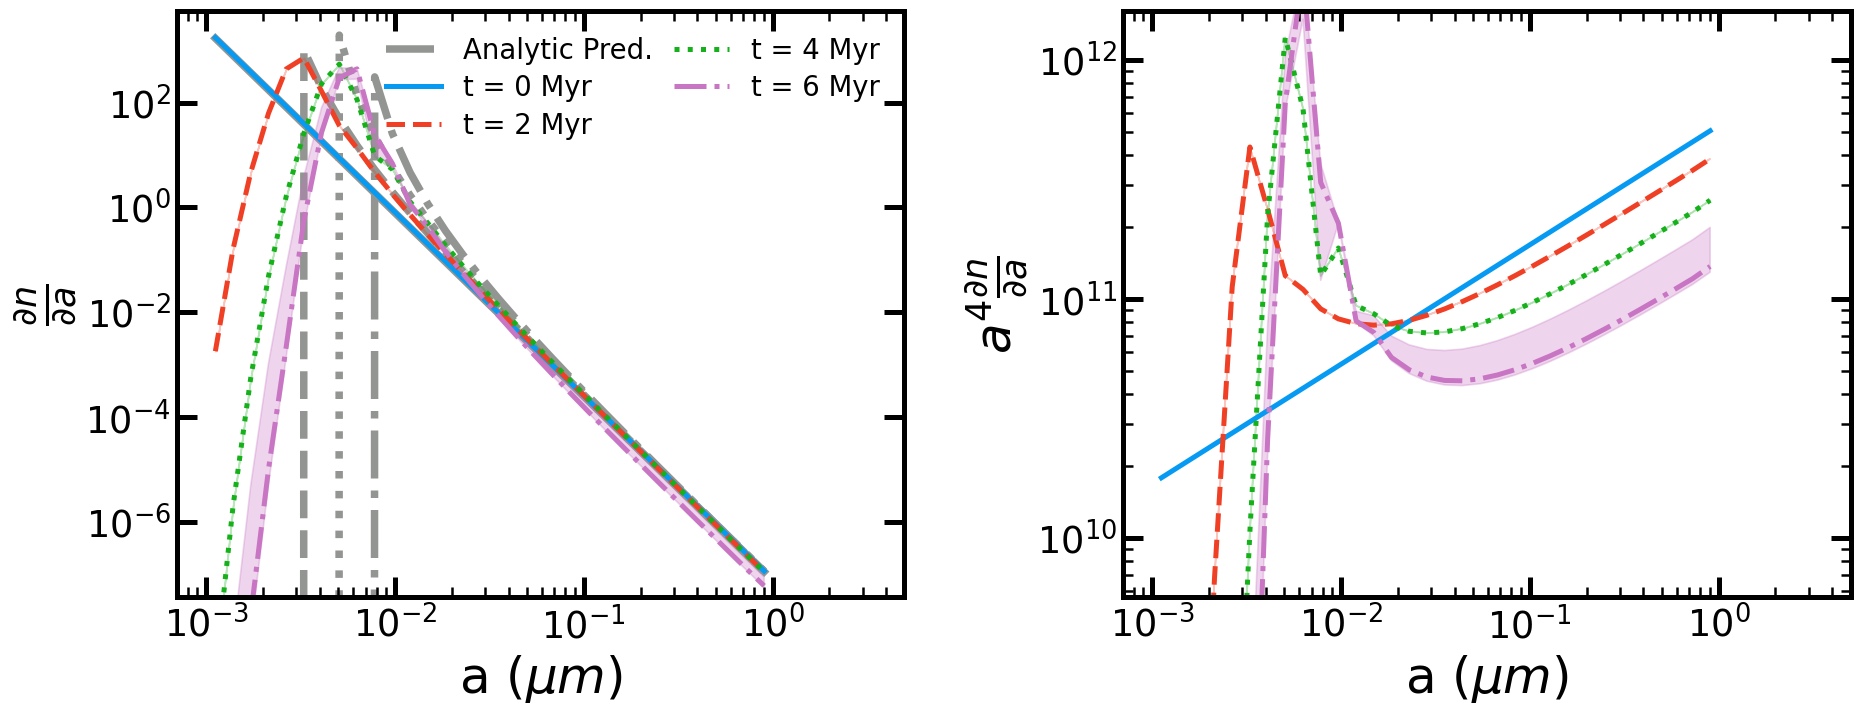

In [ ]:
for i,sim_snaps in enumerate(snaps):

    foutname = plot_dir+sim_names[i] + '_accretion_FIRE2_test.pdf'
    num_snaps = len(sim_snaps)
    fig = Figure(2,ncols=2)
    colors = config.LINE_COLORS[:num_snaps]
    linestyles = config.LINE_STYLES[:num_snaps]
    linewidth = 2*config.BASE_LINEWIDTH

    init_depl = 0

    for j,sp in enumerate(sim_snaps):
        print('snapshot time',sp.time)
        G=sp.loadpart(0)
        if j ==0:
            init_depl=np.sum(G.get_property('dust_Z')[:,7])/np.sum(G.get_property('Z_all')[:,7])
            init_spec_mass = np.sum(G.get_property('M_dust'))
            init_N_total = np.sum(G.get_property('N_grain_total'))
            print('init depletion',init_depl)
            print('init spec mass',init_spec_mass)
        analytic_dnda = gse.change_in_grain_distribution(0.001*sp.time*1E3, depl_frac = init_depl)
        spec_ind = 0
        mask = G.get_property('dust_spec')[:,spec_ind]>0
        #mask = calc.get_particle_mask(0, sp, mask_criteria='cold')

        dnda_bin_points, dnda_means, dnda_stds  =  gse.get_grain_size_dist(sp, spec_ind, mask=mask, mass=False,points_per_bin=1)
        dmda_bin_points, dmda_means, dmda_stds =  gse.get_grain_size_dist(sp, spec_ind, mask=mask, mass=True,points_per_bin=1)

        print('change in spec mass',np.sum(G.get_property('M_dust'))/init_spec_mass)
        print('change in total N grains',np.sum(G.get_property('N_grain_total'))/init_N_total)

        if j == 0:
            fig.set_axis(0, 'grain_size', 'dn/da',y_lim=[np.power(10,-0.5)*np.min(dnda_means[dnda_means>0]),np.power(10,0.5)*np.max(dnda_means)])
            fig.set_axis(1, 'grain_size', 'dm/da',y_lim=[np.power(10,-0.5)*np.min(dmda_means),np.power(10,0.5)*np.max(dmda_means)])

        fig.plot_line_data(0,dnda_bin_points,analytic_dnda(dnda_bin_points), color='xkcd:grey',linestyle=linestyles[j], linewidth=1.5*config.BASE_LINEWIDTH ,label="Analytic Pred.", zorder=-2)
        fig.plot_line_data(0,dnda_bin_points,dnda_means, color=colors[j],linestyle=linestyles[j],label="t = %.0f Myr"%snap_nums[j])
        fig.plot_shaded_region(0,dnda_bin_points,dnda_stds[:,0],dnda_stds[:,1], color=colors[j])
        fig.plot_line_data(1,dmda_bin_points,dmda_means, color=colors[j],linestyle=linestyles[j])
        fig.plot_shaded_region(1,dmda_bin_points,dmda_stds[:,0],dmda_stds[:,1], color=colors[j])

    fig.set_all_legends(max_cols=2,rescale_font=0.75)
    fig.save(foutname)

### Testing Dust-Dust Shattering

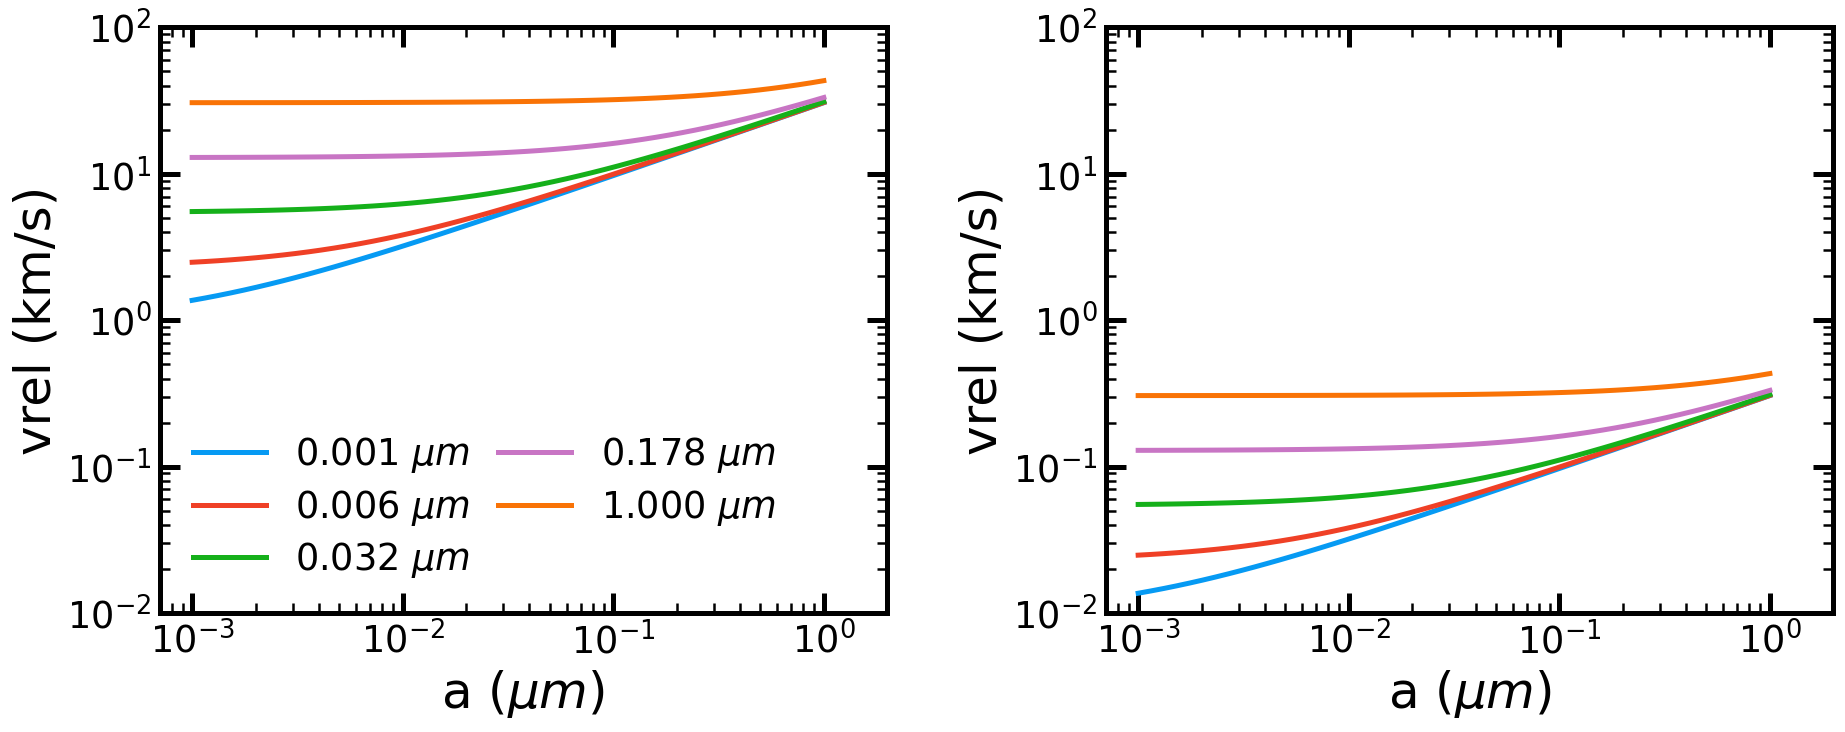

In [244]:
N=5
amin=1E-3*config.um_to_cm; amax=1E0*config.um_to_cm
a1s = np.logspace(np.log10(amin),np.log10(amax))
a2s = np.logspace(np.log10(amin),np.log10(amax),num=N)
rho_c = 3.13

fig = Figure(2,ncols=2)
colors = config.LINE_COLORS[:N]
linestyles = config.LINE_STYLES[:N]
linewidth = 2*config.BASE_LINEWIDTH

fig.set_axis(0, 'grain_size', 'velocity', y_lim=[0.01,100], y_label='vrel (km/s)',y_log=True)
fig.set_axis(1, 'grain_size', 'velocity', y_lim=[0.01,100], y_label='vrel (km/s)',y_log=True)


for i,a2 in enumerate(a2s):
    vrel = np.zeros(len(a1s))
    for j,a1 in enumerate(a1s):
        vrel[j] = gse.grain_relative_velocity(a1, a2, rho_c, 'WIM')*1E-5
    


    fig.plot_line_data(0,a1s*config.cm_to_um,vrel, color=colors[i], label='%1.3f '%(a2*config.cm_to_um) + r'$\mu m$')

for i,a2 in enumerate(a2s):
    vrel = np.zeros(len(a1s))
    for j,a1 in enumerate(a1s):
        vrel[j] = gse.grain_relative_velocity(a1, a2, rho_c,'MC')*1E-5
    


    fig.plot_line_data(1,a1s*config.cm_to_um,vrel, color=colors[i], label='%1.3f '%(a2*config.cm_to_um) + r'$\mu m$')

fig.set_all_legends()

In [250]:
amin=1E-3; amax=1E0
init_dnda = gse.lognorm_dnda
def init_dmda(a, a_norm=0.1*config.um_to_cm, sigma_a=0.6):
    return init_dnda(a, a_norm=a_norm, sigma_a=sigma_a) * 4 * np.pi / 3 * np.power(a,3)
def init_dmdloga(a, a_norm=0.1*config.um_to_cm, sigma_a=0.6):
    return init_dnda(a, a_norm=a_norm, sigma_a=sigma_a) * 4 * np.pi / 3 * np.power(a,4)
# Use this to normalize dn/da by total grain number and dm/da by total grain mass
init_dn_norm = 1/quad(init_dnda,amin,amax, args=(0.1,0.6))[0]
init_dm_norm = 1/quad(init_dmda,amin,amax, args=(0.1,0.6))[0]
bin_nums=32

ISM_phase = 'WIM'
init_depl = 0.9
dt = 0.01

a_bins,new_dnda_single,new_dmda_single  = gse.change_in_grain_distribution_from_shat_coag(dt, amin=amin,amax=amax,bin_num=bin_nums, init_dnda = init_dnda, depl_frac=init_depl, subcycle_constraints='none', ISM_phase=ISM_phase)
new_dmdloga_single = lambda a: a*new_dmda_single(a)

a_bins,new_dnda,new_dmda  = gse.change_in_grain_distribution_from_shat_coag(dt, amin=amin,amax=amax,bin_num=bin_nums, init_dnda = init_dnda, depl_frac=init_depl, subcycle_constraints='both', ISM_phase=ISM_phase)
new_dmdloga = lambda a: a*new_dmda(a)



Final changes
Mass fraction moved in given timestep 1.0
Number fraction changed in given timestep 8339.612525106882
Final changes
Mass fraction moved in given timestep 1.0
Number fraction changed in given timestep 8339.612525106882


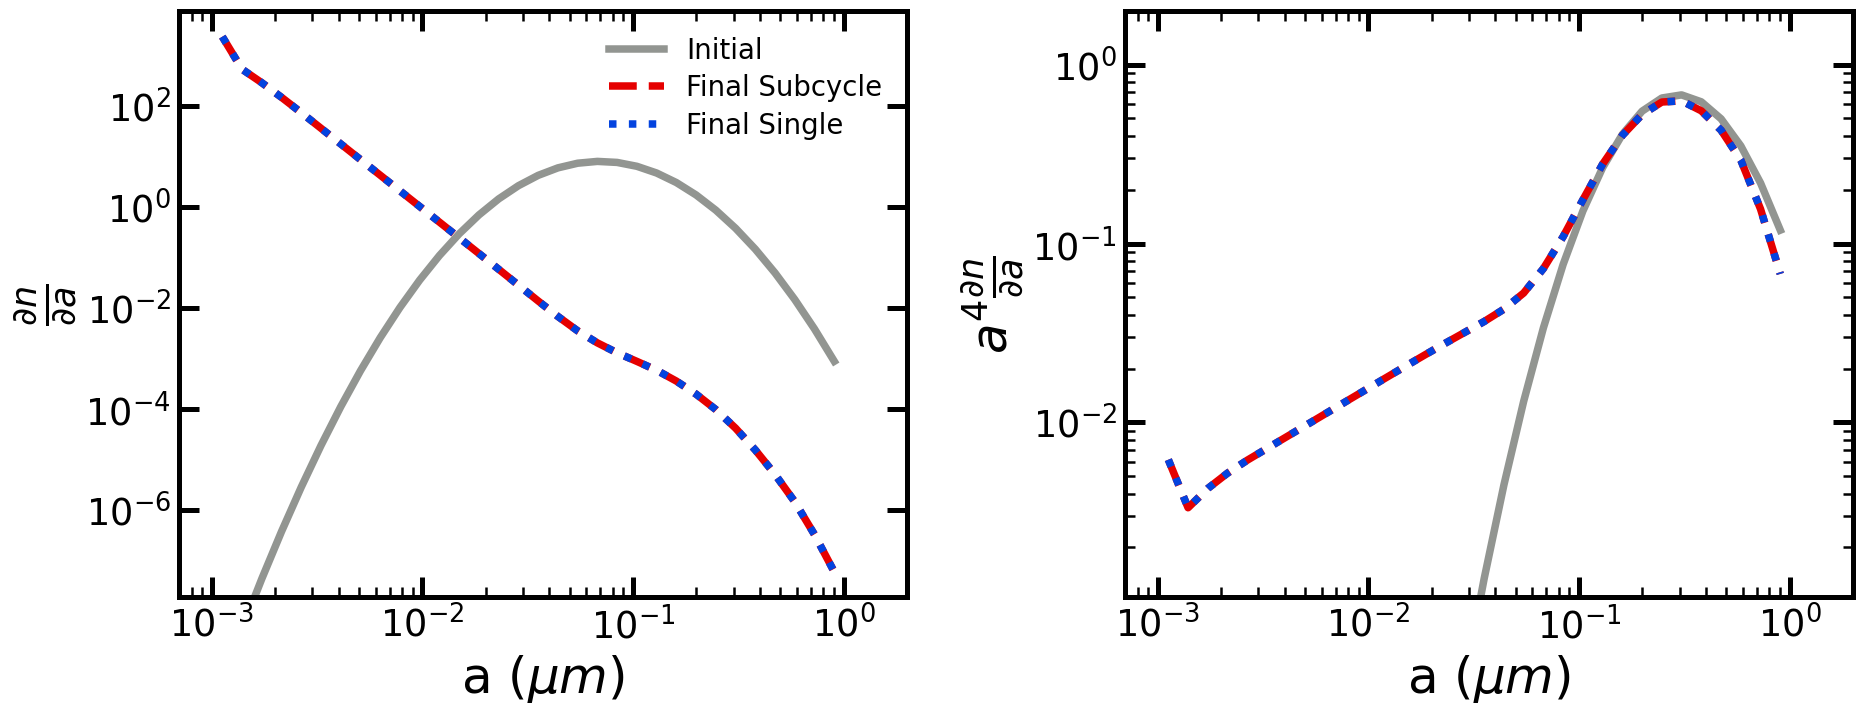

In [251]:

fig = Figure(2,ncols=2)
colors = config.LINE_COLORS[:3]
linestyles = config.LINE_STYLES[:3]
linewidth = 2*config.BASE_LINEWIDTH

fig.set_axis(0, 'grain_size', 'dn/da',y_lim=[np.power(10,-0.5)*np.min(new_dnda(a_bins)[new_dnda(a_bins)>0]),np.power(10,0.5)*np.max(new_dnda(a_bins)[new_dnda(a_bins)>0])])
fig.set_axis(1, 'grain_size', 'dm/da',y_lim=[np.power(10,-0.5)*np.min(new_dmdloga(a_bins)[new_dmdloga(a_bins)>0]),np.power(10,0.5)*np.max(new_dmdloga(a_bins)[new_dmda(a_bins)>0])])

j=0
fig.plot_line_data(0,a_bins,init_dnda(a_bins,a_norm=0.1)*init_dn_norm, color='xkcd:grey',linestyle=linestyles[0], linewidth=1.5*config.BASE_LINEWIDTH,label="Initial", zorder=-2)

fig.plot_line_data(0,a_bins,new_dnda(a_bins), color='xkcd:red',linestyle=linestyles[1], linewidth=1.5*config.BASE_LINEWIDTH,label="Final Subcycle", zorder=-2)

fig.plot_line_data(0,a_bins,new_dnda_single(a_bins), color='xkcd:blue',linestyle=linestyles[2], linewidth=1.5*config.BASE_LINEWIDTH,label="Final Single", zorder=-2)

fig.plot_line_data(1,a_bins,init_dmdloga(a_bins,a_norm=0.1)*init_dm_norm, color='xkcd:grey',linestyle=linestyles[0], linewidth=1.5*config.BASE_LINEWIDTH,label="Initial", zorder=-2)

fig.plot_line_data(1,a_bins,new_dmdloga(a_bins), color='xkcd:red',linestyle=linestyles[1], linewidth=1.5*config.BASE_LINEWIDTH,label="Final Subcycle", zorder=-2)

fig.plot_line_data(1,a_bins,new_dmdloga_single(a_bins), color='xkcd:blue',linestyle=linestyles[2], linewidth=1.5*config.BASE_LINEWIDTH,label="Final Single", zorder=-2)


fig.set_all_legends(max_cols=2,rescale_font=0.75)

### Testing Dust-Dust Coagulation

In [37]:
amin=1E-3; amax=1E0
init_dnda = gse.MRN_dnda
def init_dmda(a):
    return init_dnda(a) * 4 * np.pi / 3 * np.power(a,3)
def init_dmdloga(a):
    return init_dnda(a) * 4 * np.pi / 3 * np.power(a,4)
# Use this to normalize dn/da by total grain number and dm/da by total grain mass
init_dn_norm = 1/quad(init_dnda,amin,amax)[0]
init_dm_norm = 1/quad(init_dmda,amin,amax)[0]
bin_nums=32

ISM_phase = 'MC'
dt = 0.01
species = 'silicates'

a_bins,new_dnda_single,new_dmda_single  = gse.change_in_grain_distribution_from_shat_coag(dt, amin=amin,amax=amax,bin_num=bin_nums, init_dnda = init_dnda, subcycle_constraints=None, ISM_phase=ISM_phase, species=species)
new_dmdloga_single = lambda a: a*new_dmda_single(a)

a_bins,new_dnda,new_dmda  = gse.change_in_grain_distribution_from_shat_coag(dt, amin=amin,amax=amax,bin_num=bin_nums, init_dnda = init_dnda, subcycle_constraints='both', ISM_phase=ISM_phase, species=species)
new_dmdloga = lambda a: a*new_dmda(a)

Final changes
Mass fraction moved in given timestep 1.0090515909724427
Number fraction changed in given timestep 0.06272326822265135
Need to subcycle for 10 cycle
	 Number fraction changed 0.9195631323036956
	 Mass fraction change 0.02840045266418807
	 Change if we did not subcycle
	 Mass fraction change in given timestep 1.0090515909724427
	 Number fraction change in given timestep 0.09136615833454148
Final changes
Mass fraction moved in given timestep 0.9999999999999875
Number fraction changed in given timestep 0.2596135784139401


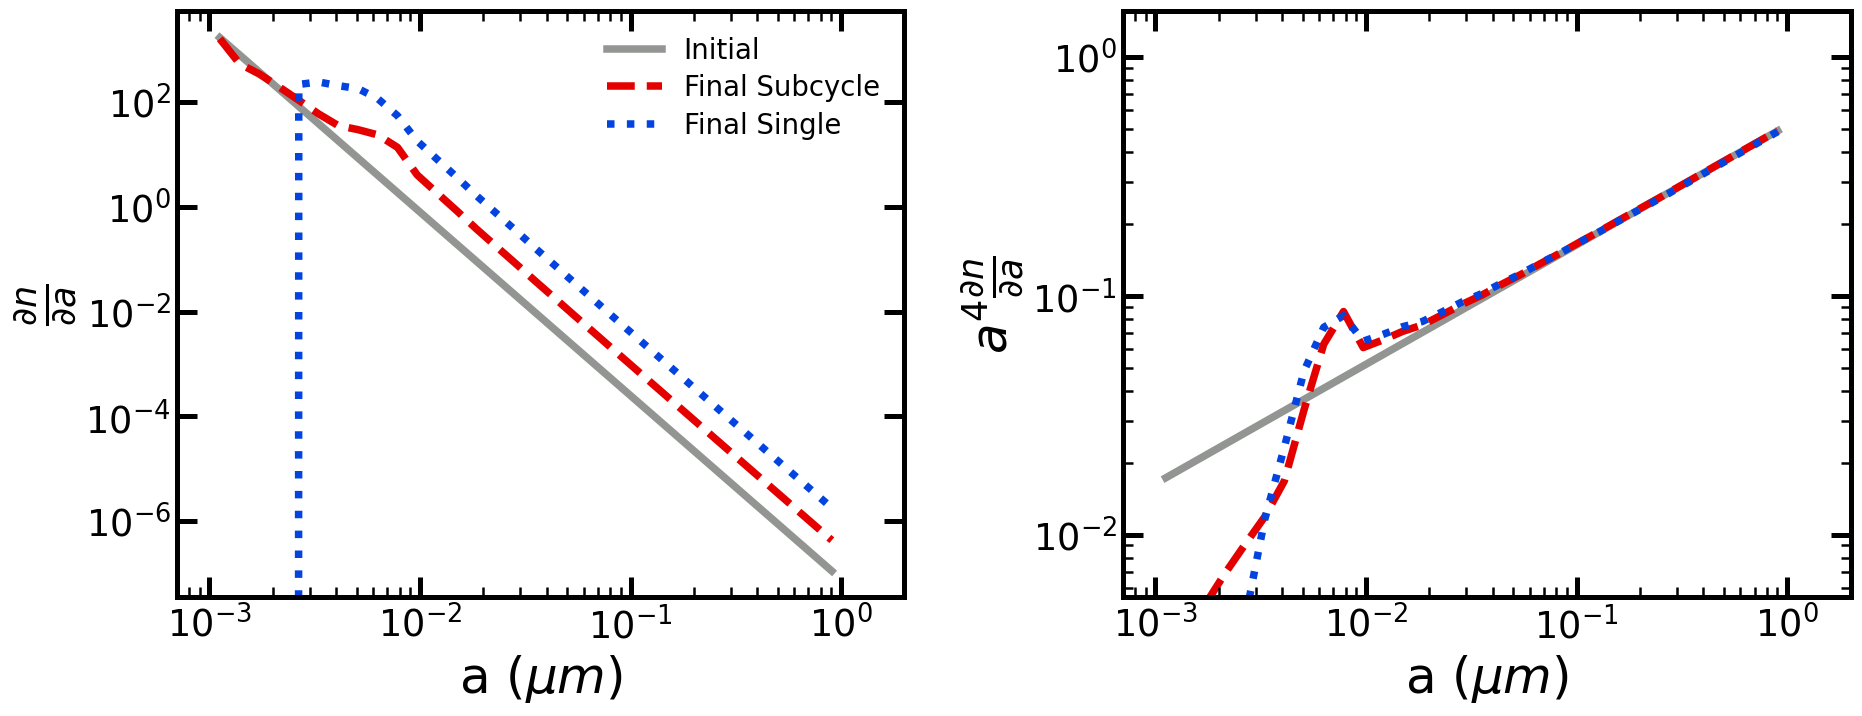

In [38]:

fig = Figure(2,ncols=2)
colors = config.LINE_COLORS[:5]
linestyles = config.LINE_STYLES[:5]
linewidth = 2*config.BASE_LINEWIDTH

fig.set_axis(0, 'grain_size', 'dn/da',y_lim=[np.power(10,-0.5)*np.min(init_dnda(a_bins)[init_dnda(a_bins)>0]*init_dn_norm),np.power(10,0.5)*np.max(init_dnda(a_bins)[init_dnda(a_bins)>0]*init_dn_norm)])
fig.set_axis(1, 'grain_size', 'dm/da',y_lim=[np.power(10,-0.5)*np.min(init_dmdloga(a_bins)[init_dmdloga(a_bins)>0]*init_dm_norm),np.power(10,0.5)*np.max(init_dmdloga(a_bins)[init_dmdloga(a_bins)>0]*init_dm_norm)])

# fig.set_axis(0, 'grain_size', 'dn/da',y_lim=[np.power(10,-0.5)*np.min(new_dnda(a_bins)[new_dnda(a_bins)>0]),np.power(10,0.5)*np.max(new_dnda(a_bins)[new_dnda(a_bins)>0])])
# fig.set_axis(1, 'grain_size', 'dm/da',y_lim=[np.power(10,-0.5)*np.min(new_dmdloga(a_bins)[new_dmdloga(a_bins)>0]),np.power(10,0.5)*np.max(new_dmdloga(a_bins)[new_dmda(a_bins)>0])])

j=0
fig.plot_line_data(0,a_bins,init_dnda(a_bins)*init_dn_norm, color='xkcd:grey',linestyle=linestyles[0], linewidth=1.5*config.BASE_LINEWIDTH,label="Initial", zorder=-2)

fig.plot_line_data(0,a_bins,new_dnda(a_bins), color='xkcd:red',linestyle=linestyles[1], linewidth=1.5*config.BASE_LINEWIDTH,label="Final Subcycle", zorder=-2)

fig.plot_line_data(0,a_bins,new_dnda_single(a_bins), color='xkcd:blue',linestyle=linestyles[2], linewidth=1.5*config.BASE_LINEWIDTH,label="Final Single", zorder=-2)

fig.plot_line_data(1,a_bins,init_dmdloga(a_bins)*init_dm_norm, color='xkcd:grey',linestyle=linestyles[0], linewidth=1.5*config.BASE_LINEWIDTH,label="Initial", zorder=-2)

fig.plot_line_data(1,a_bins,new_dmdloga(a_bins), color='xkcd:red',linestyle=linestyles[1], linewidth=1.5*config.BASE_LINEWIDTH,label="Final Subcycle", zorder=-2)

fig.plot_line_data(1,a_bins,new_dmdloga_single(a_bins), color='xkcd:blue',linestyle=linestyles[2], linewidth=1.5*config.BASE_LINEWIDTH,label="Final Single", zorder=-2)


fig.set_all_legends(max_cols=2,rescale_font=0.75)

# Appendix Plots

## Dust size distribution change for various processes
Create some useful plots showing how an MRN size distribtuion will change due to each dust process along with general timescales for each

#### Coagulation

silicates
Need to subcycle for 10 cycle
	 Number fraction changed 0.9383602663795003
	 Mass fraction change 0.028100009486428205
	 Change if we did not subcycle
	 Mass fraction change in given timestep 1.0092163937928003
	 Number fraction change in given timestep 0.0718594959885927
Final changes
Mass fraction moved in given timestep 0.999999999999985
Number fraction changed in given timestep 0.251273211802515
carbonaceous
Need to subcycle for 10 cycle
	 Number fraction changed 0.9897809776068868
	 Mass fraction change 0.07680564002683657
	 Change if we did not subcycle
	 Mass fraction change in given timestep 1.036324406061921
	 Number fraction change in given timestep 0.010829327170074825
Final changes
Mass fraction moved in given timestep 1.0000000000055247
Number fraction changed in given timestep 0.14006306755246423
iron
Need to subcycle for 10 cycle
	 Number fraction changed 0.9732448221969247
	 Mass fraction change 0.081406752264592
	 Change if we did not subcycle
	 Mass fraction

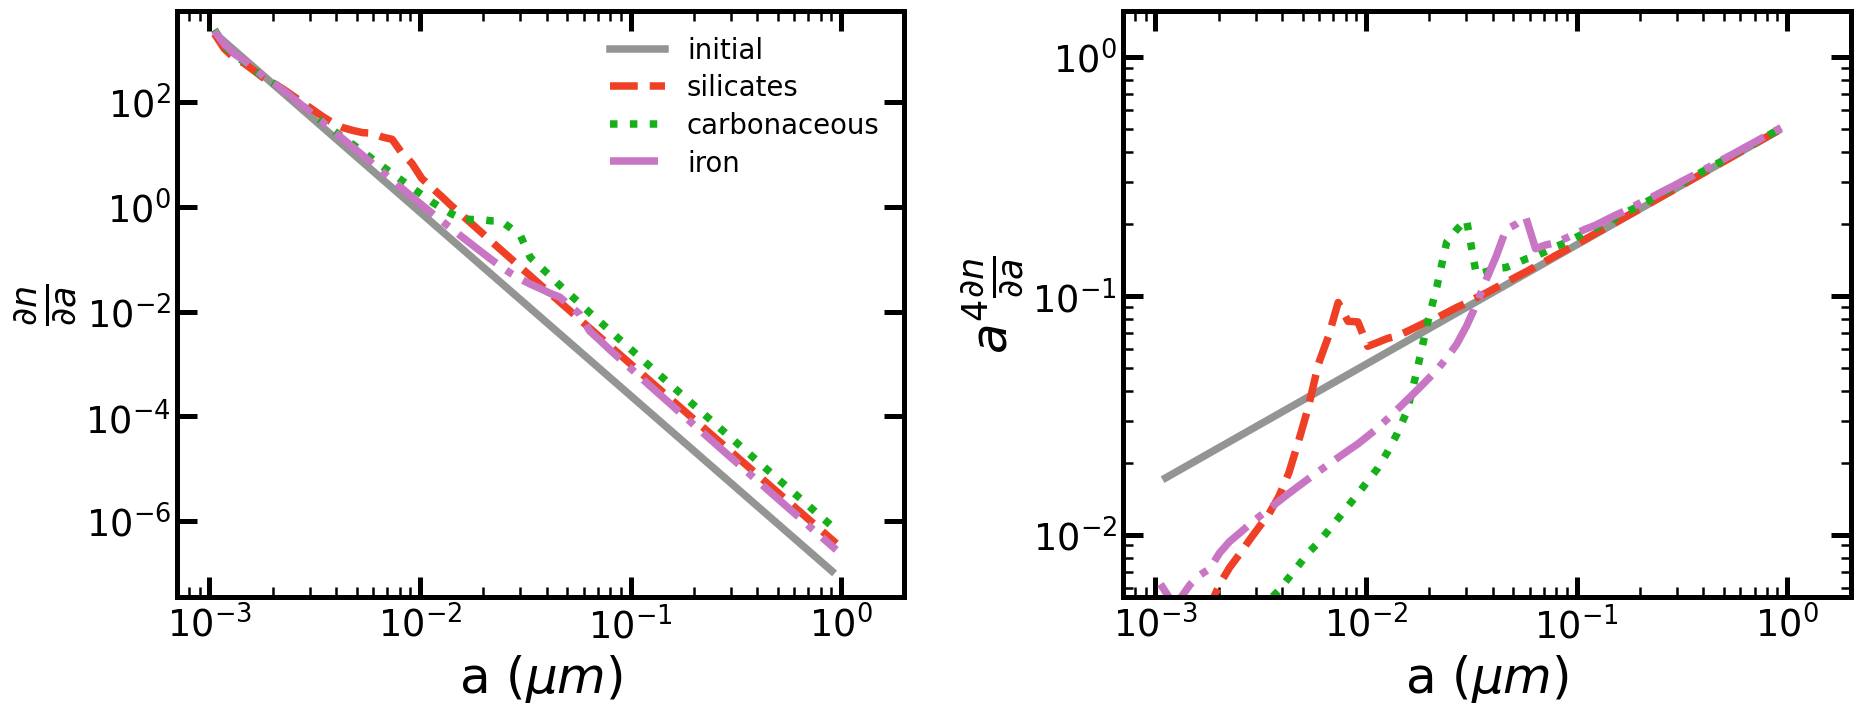

In [203]:
foutname = plot_dir+'analytical_coagulation_pred.pdf'

amin=1E-3; amax=1E0
init_dnda = gse.MRN_dnda
def init_dmda(a):
    return init_dnda(a) * 4 * np.pi / 3 * np.power(a,3)
def init_dmdloga(a):
    return init_dnda(a) * 4 * np.pi / 3 * np.power(a,4)
# Use this to normalize dn/da by total grain number and dm/da by total grain mass
init_dn_norm = 1/quad(init_dnda,amin,amax)[0]
init_dm_norm = 1/quad(init_dmda,amin,amax)[0]
bin_nums=64


fig = Figure(2,ncols=2)
colors = config.LINE_COLORS[:5]
linestyles = config.LINE_STYLES[:5]
linewidth = 2*config.BASE_LINEWIDTH
fig.set_axis(0, 'grain_size', 'dn/da',y_lim=[np.power(10,-0.5)*np.min(init_dnda(a_bins)[init_dnda(a_bins)>0]*init_dn_norm),np.power(10,0.5)*np.max(init_dnda(a_bins)[init_dnda(a_bins)>0]*init_dn_norm)])
fig.set_axis(1, 'grain_size', 'dm/da',y_lim=[np.power(10,-0.5)*np.min(init_dmdloga(a_bins)[init_dmdloga(a_bins)>0]*init_dm_norm),np.power(10,0.5)*np.max(init_dmdloga(a_bins)[init_dmdloga(a_bins)>0]*init_dm_norm)])


fig.plot_line_data(0,a_bins,init_dnda(a_bins)*init_dn_norm, color='xkcd:grey',linestyle=linestyles[0], linewidth=1.5*config.BASE_LINEWIDTH,label="initial", zorder=-2)
fig.plot_line_data(1,a_bins,init_dmdloga(a_bins)*init_dm_norm, color='xkcd:grey',linestyle=linestyles[0], linewidth=1.5*config.BASE_LINEWIDTH,label="initial", zorder=-2)

species = ['silicates','carbonaceous','iron']
ISM_phase = 'MC'
dt = 0.01
subcycle_constraint = 'both'

for i,spec in enumerate(species):
    print(spec)
    a_bins, dnda, dmda  = gse.change_in_grain_distribution_from_shat_coag(dt, amin=amin,amax=amax,bin_num=bin_nums, init_dnda = init_dnda, subcycle_constraints=subcycle_constraint, ISM_phase=ISM_phase, species=spec)
    dmdloga = lambda a: a*dmda(a)

    fig.plot_line_data(0,a_bins,dnda(a_bins), color=colors[i+1],linestyle=linestyles[i+1], linewidth=1.5*config.BASE_LINEWIDTH,label=spec)

    fig.plot_line_data(1,a_bins,dmdloga(a_bins), color=colors[i+1],linestyle=linestyles[i+1], linewidth=1.5*config.BASE_LINEWIDTH,label=spec)

fig.set_all_legends(max_cols=2,rescale_font=0.75)
fig.save(foutname)


#### Shattering
Note the increase at the smallest grain size bin is due to rebinning shattered fragments beyond the minimum grain size back to the smallest bin.

silicates
Final changes
Mass fraction moved in given timestep 0.9999999999996048
Number fraction changed in given timestep 1.9672999898340804
carbonaceous
Need to subcycle for 2 cycle
	 Number fraction changed 2.6213796156350297e-07
	 Mass fraction change 0.11755711061816887
	 Change if we did not subcycle
	 Mass fraction change in given timestep 0.999999999999758
	 Number fraction change in given timestep 2.986902074443427
Final changes
Mass fraction moved in given timestep 0.9999999999996227
Number fraction changed in given timestep 3.2067571467830542
iron
Need to subcycle for 2 cycle
	 Number fraction changed 3.88555055797319e-07
	 Mass fraction change 0.1751400902298457
	 Change if we did not subcycle
	 Mass fraction change in given timestep 0.9999999999999732
	 Number fraction change in given timestep 3.396959354015373
Final changes
Mass fraction moved in given timestep 1.000000000000108
Number fraction changed in given timestep 3.8661923663590456


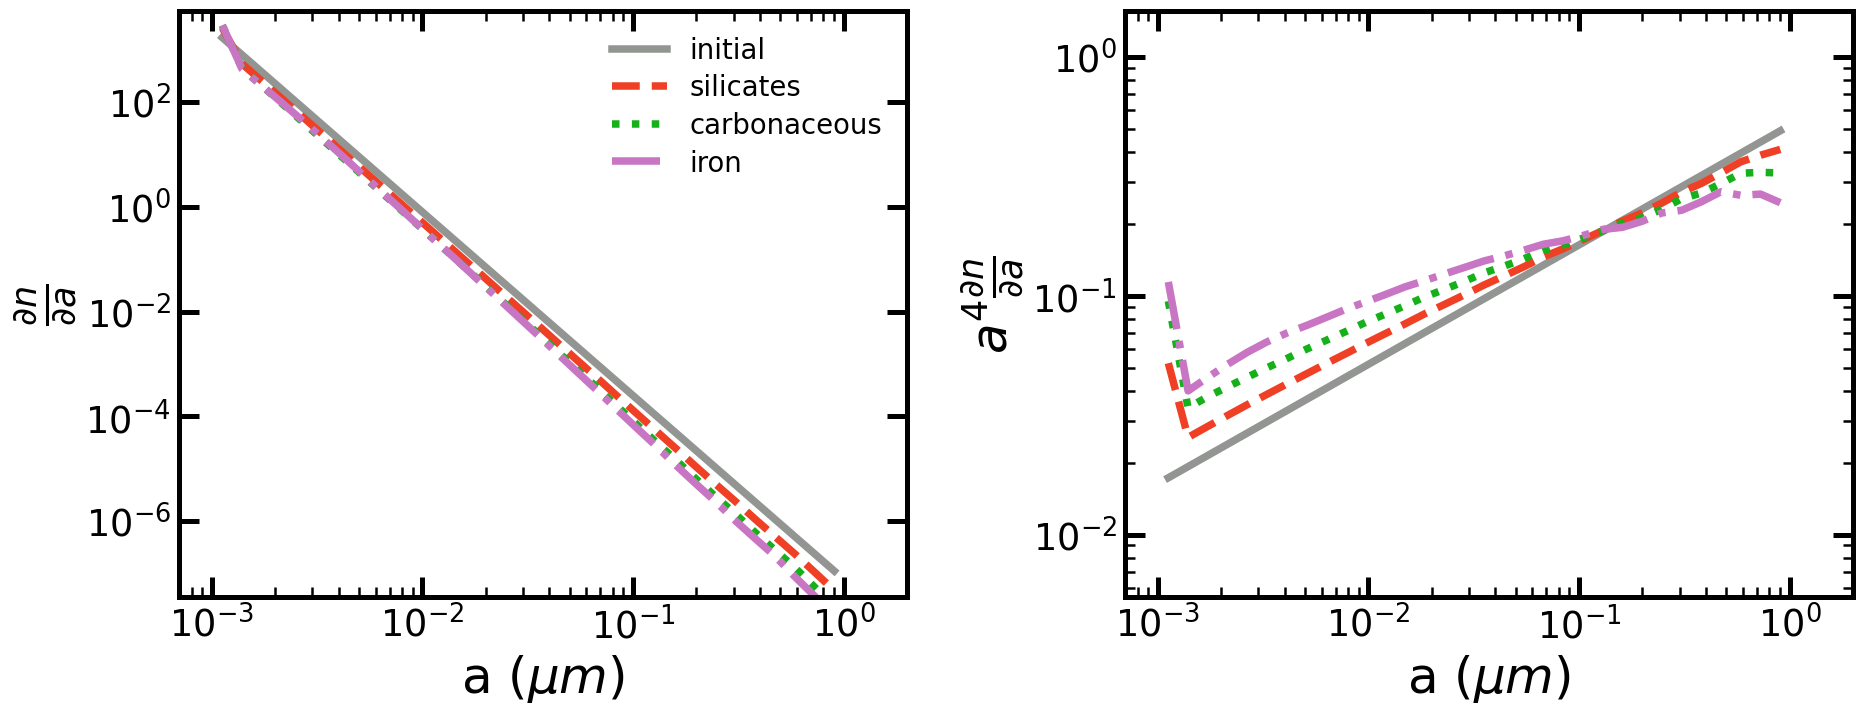

In [238]:
foutname = plot_dir+'analytical_shattering_pred.pdf'

amin=1E-3; amax=1E0
init_dnda = gse.MRN_dnda
def init_dmda(a):
    return init_dnda(a) * 4 * np.pi / 3 * np.power(a,3)
def init_dmdloga(a):
    return init_dnda(a) * 4 * np.pi / 3 * np.power(a,4)
# Use this to normalize dn/da by total grain number and dm/da by total grain mass
init_dn_norm = 1/quad(init_dnda,amin,amax)[0]
init_dm_norm = 1/quad(init_dmda,amin,amax)[0]
bin_nums=32

fig = Figure(2,ncols=2)
colors = config.LINE_COLORS[:5]
linestyles = config.LINE_STYLES[:5]
linewidth = 2*config.BASE_LINEWIDTH
fig.set_axis(0, 'grain_size', 'dn/da',y_lim=[np.power(10,-0.5)*np.min(init_dnda(a_bins)[init_dnda(a_bins)>0]*init_dn_norm),np.power(10,0.5)*np.max(init_dnda(a_bins)[init_dnda(a_bins)>0]*init_dn_norm)])
fig.set_axis(1, 'grain_size', 'dm/da',y_lim=[np.power(10,-0.5)*np.min(init_dmdloga(a_bins)[init_dmdloga(a_bins)>0]*init_dm_norm),np.power(10,0.5)*np.max(init_dmdloga(a_bins)[init_dmdloga(a_bins)>0]*init_dm_norm)])


fig.plot_line_data(0,a_bins,init_dnda(a_bins)*init_dn_norm, color='xkcd:grey',linestyle=linestyles[0], linewidth=1.5*config.BASE_LINEWIDTH,label="initial", zorder=-2)
fig.plot_line_data(1,a_bins,init_dmdloga(a_bins)*init_dm_norm, color='xkcd:grey',linestyle=linestyles[0], linewidth=1.5*config.BASE_LINEWIDTH,label="initial", zorder=-2)

species = ['silicates','carbonaceous','iron']
ISM_phase = 'WIM'
init_depl = 0.2
dt = 0.02
subcycle_constraints='both'

for i,spec in enumerate(species):
    print(spec)
    a_bins, dnda, dmda  = gse.change_in_grain_distribution_from_shat_coag(dt, amin=amin,amax=amax,bin_num=bin_nums, init_dnda = init_dnda, depl_frac=init_depl, subcycle_constraints=subcycle_constraints, ISM_phase=ISM_phase, species=spec)
    dmdloga = lambda a: a*dmda(a)

    fig.plot_line_data(0,a_bins,dnda(a_bins), color=colors[i+1],linestyle=linestyles[i+1], linewidth=1.5*config.BASE_LINEWIDTH,label=spec)

    fig.plot_line_data(1,a_bins,dmdloga(a_bins), color=colors[i+1],linestyle=linestyles[i+1], linewidth=1.5*config.BASE_LINEWIDTH,label=spec)

fig.set_all_legends(max_cols=2,rescale_font=0.75)
fig.save(foutname)


silicates
Final changes
Mass fraction moved in given timestep 1.0
Number fraction changed in given timestep 2317.281240956507
carbonaceous
Final changes
Mass fraction moved in given timestep 1.0
Number fraction changed in given timestep 2093.7846551695084
iron
Final changes
Mass fraction moved in given timestep 1.0
Number fraction changed in given timestep 646.2330516381857


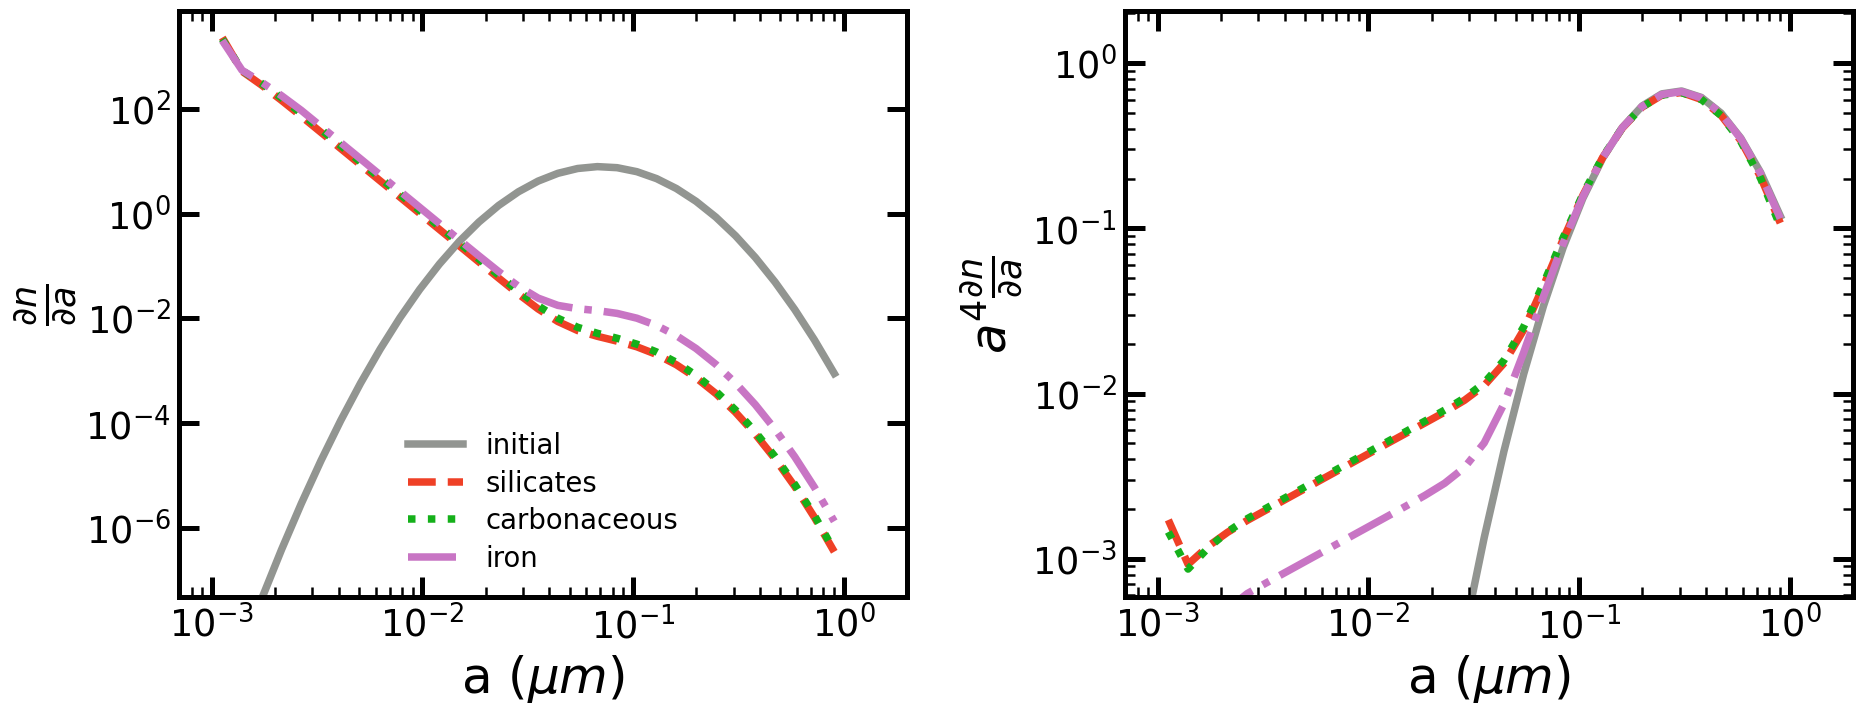

In [249]:
foutname = plot_dir+'analytical_shattering_pred.pdf'

amin=1E-3; amax=1E0
init_dnda = gse.lognorm_dnda
def init_dmda(a, a_norm=0.1*config.um_to_cm, sigma_a=0.6):
    return init_dnda(a, a_norm=a_norm, sigma_a=sigma_a) * 4 * np.pi / 3 * np.power(a,3)
def init_dmdloga(a, a_norm=0.1*config.um_to_cm, sigma_a=0.6):
    return init_dnda(a, a_norm=a_norm, sigma_a=sigma_a) * 4 * np.pi / 3 * np.power(a,4)
# Use this to normalize dn/da by total grain number and dm/da by total grain mass
init_dn_norm = 1/quad(init_dnda,amin,amax, args=(0.1,0.6))[0]
init_dm_norm = 1/quad(init_dmda,amin,amax, args=(0.1,0.6))[0]
bin_nums=32


fig = Figure(2,ncols=2)
colors = config.LINE_COLORS[:5]
linestyles = config.LINE_STYLES[:5]
linewidth = 2*config.BASE_LINEWIDTH


fig.plot_line_data(0,a_bins,init_dnda(a_bins,a_norm=0.1)*init_dn_norm, color='xkcd:grey',linestyle=linestyles[0], linewidth=1.5*config.BASE_LINEWIDTH,label="initial", zorder=-2)
fig.plot_line_data(1,a_bins,init_dmdloga(a_bins,a_norm=0.1)*init_dm_norm, color='xkcd:grey',linestyle=linestyles[0], linewidth=1.5*config.BASE_LINEWIDTH,label="initial", zorder=-2)

fig.set_axis(0, 'grain_size', 'dn/da',y_lim=[np.power(10,-0.5)*np.min(new_dnda(a_bins)[new_dnda(a_bins)>0]),np.power(10,0.5)*np.max(new_dnda(a_bins)[new_dnda(a_bins)>0])])
fig.set_axis(1, 'grain_size', 'dm/da',y_lim=[np.power(10,-0.5)*np.min(new_dmdloga(a_bins)[new_dmdloga(a_bins)>0]),np.power(10,0.5)*np.max(new_dmdloga(a_bins)[new_dmda(a_bins)>0])])


species = ['silicates','carbonaceous','iron']
ISM_phase = 'WIM'
init_depl = 0.5
dt = 0.005
subcycle_constraints='both'

for i,spec in enumerate(species):
    print(spec)
    a_bins, dnda, dmda  = gse.change_in_grain_distribution_from_shat_coag(dt, amin=amin,amax=amax,bin_num=bin_nums, init_dnda = init_dnda, depl_frac=init_depl, subcycle_constraints=subcycle_constraints, ISM_phase=ISM_phase, species=spec)
    dmdloga = lambda a: a*dmda(a)

    fig.plot_line_data(0,a_bins,dnda(a_bins), color=colors[i+1],linestyle=linestyles[i+1], linewidth=1.5*config.BASE_LINEWIDTH,label=spec)

    fig.plot_line_data(1,a_bins,dmdloga(a_bins), color=colors[i+1],linestyle=linestyles[i+1], linewidth=1.5*config.BASE_LINEWIDTH,label=spec)

fig.set_all_legends(max_cols=2,rescale_font=0.75)
fig.save(foutname)


#### Accretion

silicates
Clumping factor 3.7209810129834526
Predicted dadt (um/Gyr): 0.21885280985172598
Min bin width used for subcyling 0.00011397385999480242
Total cycles needed 65.0 Subcycle timestep 0.00015384615384615385
Change in total grain number 0.9999999997944659
Change in total grain mass 1.5285727847576704
Initial and final depletion fraction 0.1 0.1528572784757672
carbonaceous
Clumping factor 3.3863283482060633
Predicted dadt (um/Gyr): 0.29406364866365176
Min bin width used for subcyling 0.00011397385999480242
Total cycles needed 87.0 Subcycle timestep 0.00011494252873563218
Change in total grain number 0.9999999997271909
Change in total grain mass 1.8702670966493389
Initial and final depletion fraction 0.1 0.18702670966493387
iron
Clumping factor 3.7209810129834526
Predicted dadt (um/Gyr): 0.023397390886685077
Min bin width used for subcyling 0.00011397385999480242
Total cycles needed 7.0 Subcycle timestep 0.0014285714285714286
Change in total grain number 0.9999999999776391
Change in 

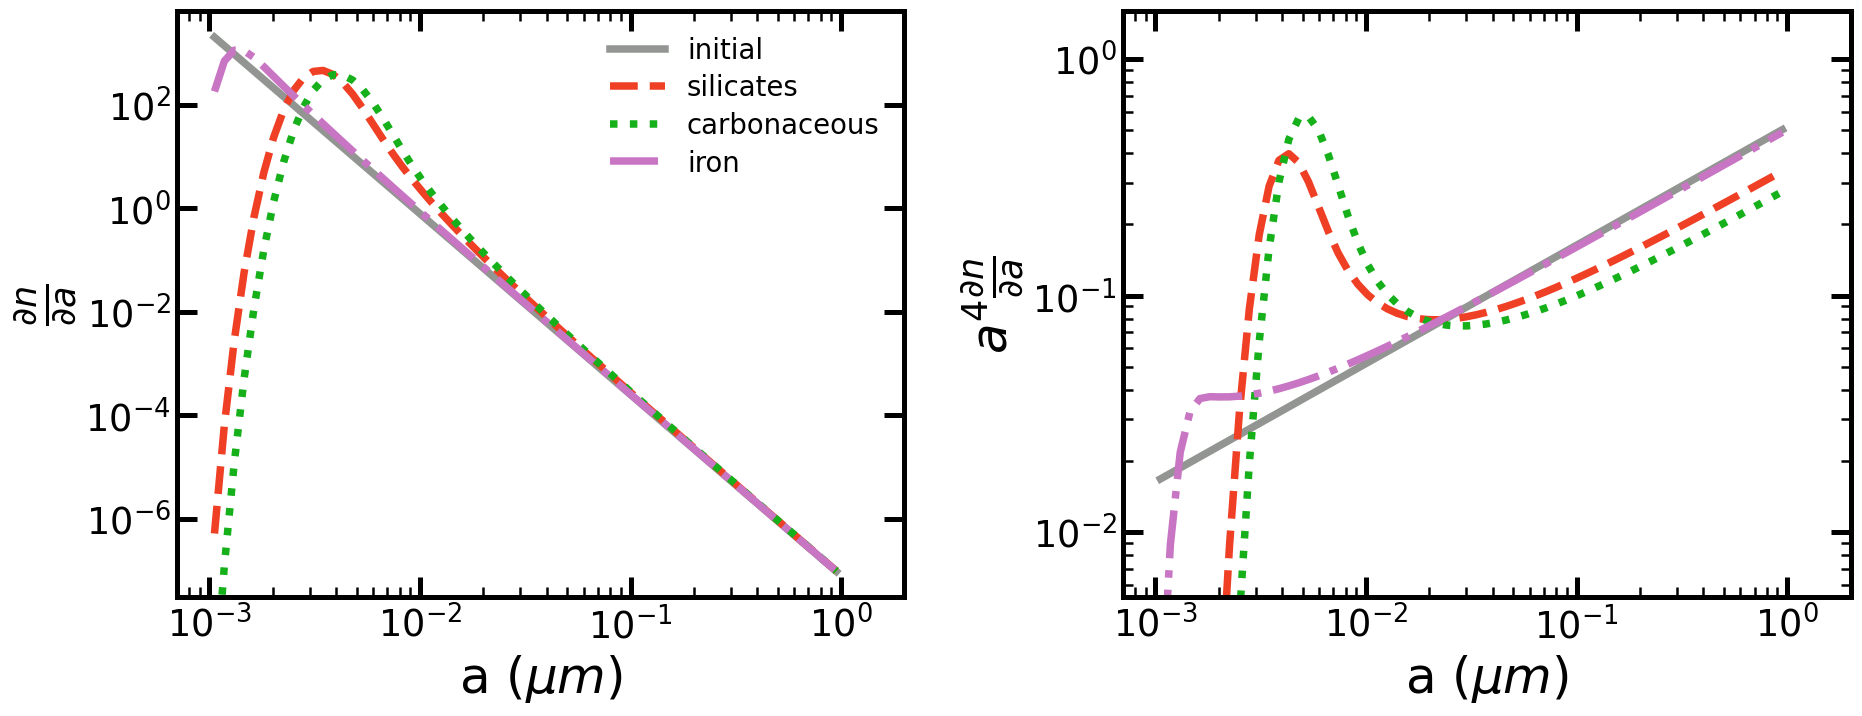

In [200]:
foutname = plot_dir+'analytical_accretion_pred.pdf'

amin=1E-3; amax=1E0
init_dnda = gse.MRN_dnda
def init_dmda(a):
    return init_dnda(a) * 4 * np.pi / 3 * np.power(a,3)
def init_dmdloga(a):
    return init_dnda(a) * 4 * np.pi / 3 * np.power(a,4)
# Use this to normalize dn/da by total grain number and dm/da by total grain mass
init_dn_norm = 1/quad(init_dnda,amin,amax)[0]
init_dm_norm = 1/quad(init_dmda,amin,amax)[0]
bin_nums=64


fig = Figure(2,ncols=2)
colors = config.LINE_COLORS[:5]
linestyles = config.LINE_STYLES[:5]
linewidth = 2*config.BASE_LINEWIDTH
fig.set_axis(0, 'grain_size', 'dn/da',y_lim=[np.power(10,-0.5)*np.min(init_dnda(a_bins)[init_dnda(a_bins)>0]*init_dn_norm),np.power(10,0.5)*np.max(init_dnda(a_bins)[init_dnda(a_bins)>0]*init_dn_norm)])
fig.set_axis(1, 'grain_size', 'dm/da',y_lim=[np.power(10,-0.5)*np.min(init_dmdloga(a_bins)[init_dmdloga(a_bins)>0]*init_dm_norm),np.power(10,0.5)*np.max(init_dmdloga(a_bins)[init_dmdloga(a_bins)>0]*init_dm_norm)])


fig.plot_line_data(0,a_bins,init_dnda(a_bins)*init_dn_norm, color='xkcd:grey',linestyle=linestyles[0], linewidth=1.5*config.BASE_LINEWIDTH,label="initial", zorder=-2)
fig.plot_line_data(1,a_bins,init_dmdloga(a_bins)*init_dm_norm, color='xkcd:grey',linestyle=linestyles[0], linewidth=1.5*config.BASE_LINEWIDTH,label="initial", zorder=-2)

species = ['silicates','carbonaceous','iron']
ISM_phase = 'CNM'
dt = 0.01
init_depl = 0.1 # initial depletion of key element for dust species
subcycle_constraints='min_bin'

for i,spec in enumerate(species):
    print(spec)
    a_bins, dnda, dmda  = gse.change_in_grain_distribution_from_acc_sput(dt, amin=amin,amax=amax,bin_num=bin_nums, init_dnda = init_dnda, ISM_phase=ISM_phase, subcycle_constraints=subcycle_constraints, species=spec, depl_frac=init_depl)

    fig.plot_line_data(0,a_bins,dnda(a_bins), color=colors[i+1],linestyle=linestyles[i+1], linewidth=1.5*config.BASE_LINEWIDTH,label=spec)

    fig.plot_line_data(1,a_bins,dmdloga(a_bins), color=colors[i+1],linestyle=linestyles[i+1], linewidth=1.5*config.BASE_LINEWIDTH,label=spec)

fig.set_all_legends(max_cols=2,rescale_font=0.75)
fig.save(foutname)


Testing different subcycling prescriptions.
Decided on using the minimum bin.

none
Total cycles needed 1 Subcycle timestep 0.001
Change in total grain number 0.999999999950777
Change in total grain mass 1.0886402476238488
Initial and final depletion fraction 0.1 0.10886402476238488
size
Total cycles needed 1 Subcycle timestep 0.001
Change in total grain number 0.999999999950777
Change in total grain mass 1.0886402476238488
Initial and final depletion fraction 0.1 0.10886402476238488
min_bin
0.00024093776075171964
Total cycles needed 6.0 Subcycle timestep 0.00016666666666666666
Change in total grain number 0.9999999999510447
Change in total grain mass 1.104806641333839
Initial and final depletion fraction 0.1 0.11048066413338391


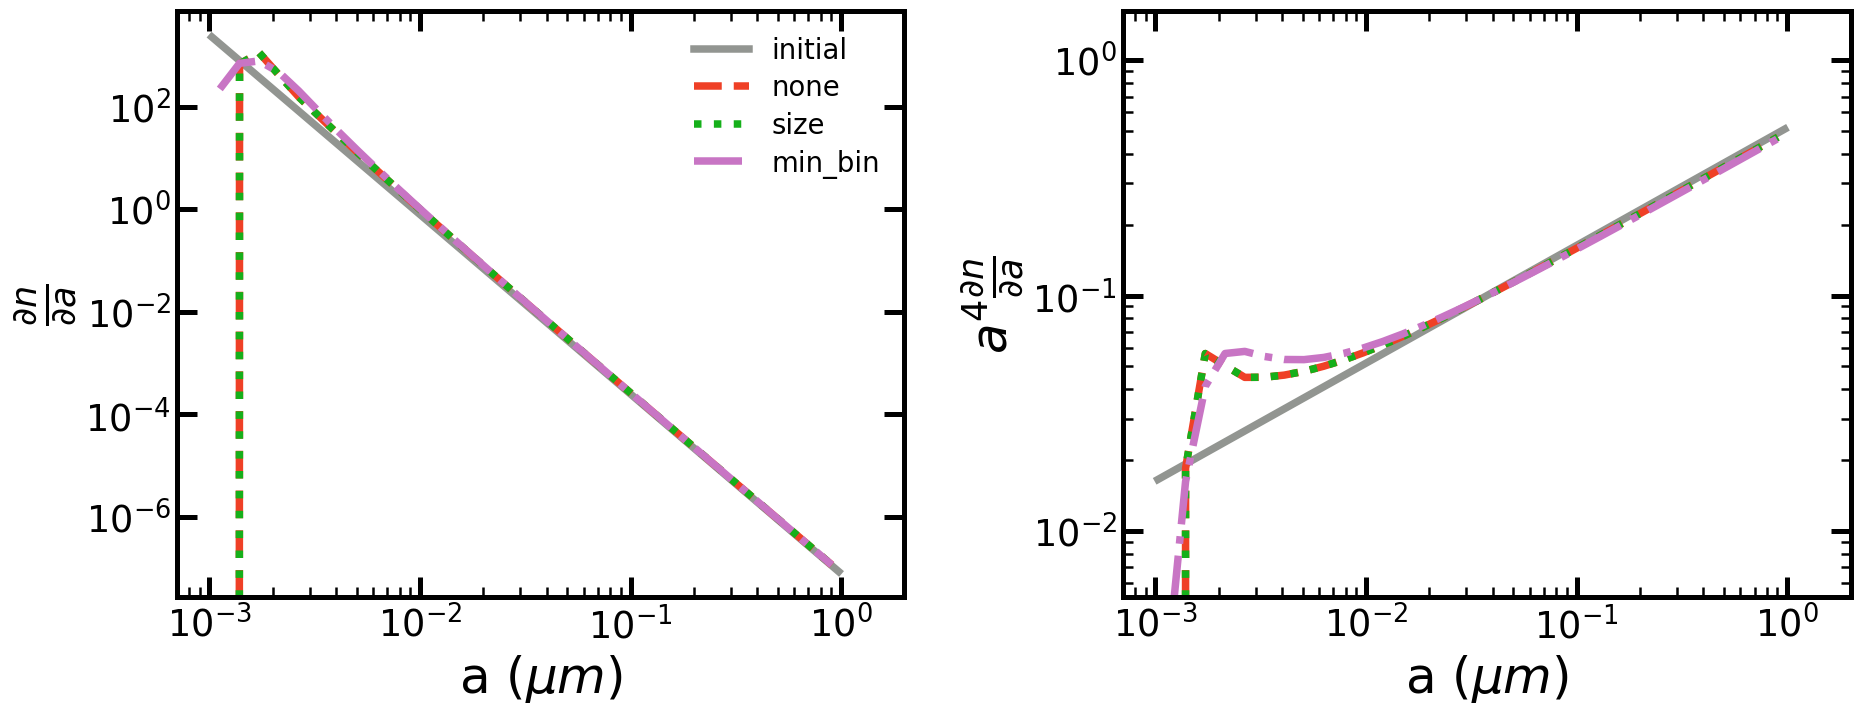

In [174]:
foutname = 'analytical_acretion_pred_subcycling_comparisons.pdf'

amin=1E-3; amax=1E0
init_dnda = gse.MRN_dnda
def init_dmda(a):
    return init_dnda(a) * 4 * np.pi / 3 * np.power(a,3)
def init_dmdloga(a):
    return init_dnda(a) * 4 * np.pi / 3 * np.power(a,4)
# Use this to normalize dn/da by total grain number and dm/da by total grain mass
init_dn_norm = 1/quad(init_dnda,amin,amax)[0]
init_dm_norm = 1/quad(init_dmda,amin,amax)[0]
bin_nums=32


fig = Figure(2,ncols=2)
colors = config.LINE_COLORS[:5]
linestyles = config.LINE_STYLES[:5]
linewidth = 2*config.BASE_LINEWIDTH
fig.set_axis(0, 'grain_size', 'dn/da',y_lim=[np.power(10,-0.5)*np.min(init_dnda(a_bins)[init_dnda(a_bins)>0]*init_dn_norm),np.power(10,0.5)*np.max(init_dnda(a_bins)[init_dnda(a_bins)>0]*init_dn_norm)])
fig.set_axis(1, 'grain_size', 'dm/da',y_lim=[np.power(10,-0.5)*np.min(init_dmdloga(a_bins)[init_dmdloga(a_bins)>0]*init_dm_norm),np.power(10,0.5)*np.max(init_dmdloga(a_bins)[init_dmdloga(a_bins)>0]*init_dm_norm)])


fig.plot_line_data(0,a_bins,init_dnda(a_bins)*init_dn_norm, color='xkcd:grey',linestyle=linestyles[0], linewidth=1.5*config.BASE_LINEWIDTH,label="initial", zorder=-2)
fig.plot_line_data(1,a_bins,init_dmdloga(a_bins)*init_dm_norm, color='xkcd:grey',linestyle=linestyles[0], linewidth=1.5*config.BASE_LINEWIDTH,label="initial", zorder=-2)

spec = 'silicates'
ISM_phase = 'CNM'
dt = 0.001
init_depl = 0.1 # initial depletion of key element for dust species
subcycle_constraints=['none','size','min_bin']

for i,subcycle in enumerate(subcycle_constraints):
    print(subcycle)
    a_bins, dnda, dmda  = gse.change_in_grain_distribution_from_acc_sput(dt, amin=amin,amax=amax,bin_num=bin_nums, init_dnda = init_dnda, ISM_phase=ISM_phase, subcycle_constraints=subcycle, species=spec, depl_frac=init_depl)

    fig.plot_line_data(0,a_bins,dnda(a_bins), color=colors[i+1],linestyle=linestyles[i+1], linewidth=1.5*config.BASE_LINEWIDTH,label=subcycle)

    fig.plot_line_data(1,a_bins,dmdloga(a_bins), color=colors[i+1],linestyle=linestyles[i+1], linewidth=1.5*config.BASE_LINEWIDTH,label=subcycle)

fig.set_all_legends(max_cols=2,rescale_font=0.75)
fig.save(foutname)


#### Thermal Sputtering

silicates
Predicted dadt (um/Gyr): -0.9199920004722989
Min bin width used for subcyling 0.00011397385999480242
Total cycles needed 2691.0 Subcycle timestep 3.716090672612412e-05
Change in total grain number 1.5126259679420442e-05
Change in total grain mass 0.35256246297961885
Initial and final depletion fraction 0.1 0.035256246297961855
carbonaceous
Predicted dadt (um/Gyr): -0.45783220029913224
Min bin width used for subcyling 0.00011397385999480242
Total cycles needed 1339.0 Subcycle timestep 7.468259895444362e-05
Change in total grain number 8.428418972989833e-05
Change in total grain mass 0.5079015169690576
Initial and final depletion fraction 0.1 0.05079015169690579
iron
Predicted dadt (um/Gyr): -0.43646272260277963
Min bin width used for subcyling 0.00011397385999480242
Total cycles needed 1277.0 Subcycle timestep 7.830853563038371e-05
Change in total grain number 9.472373982720711e-05
Change in total grain mass 0.5178300341299557
Initial and final depletion fraction 0.1 0.0517830

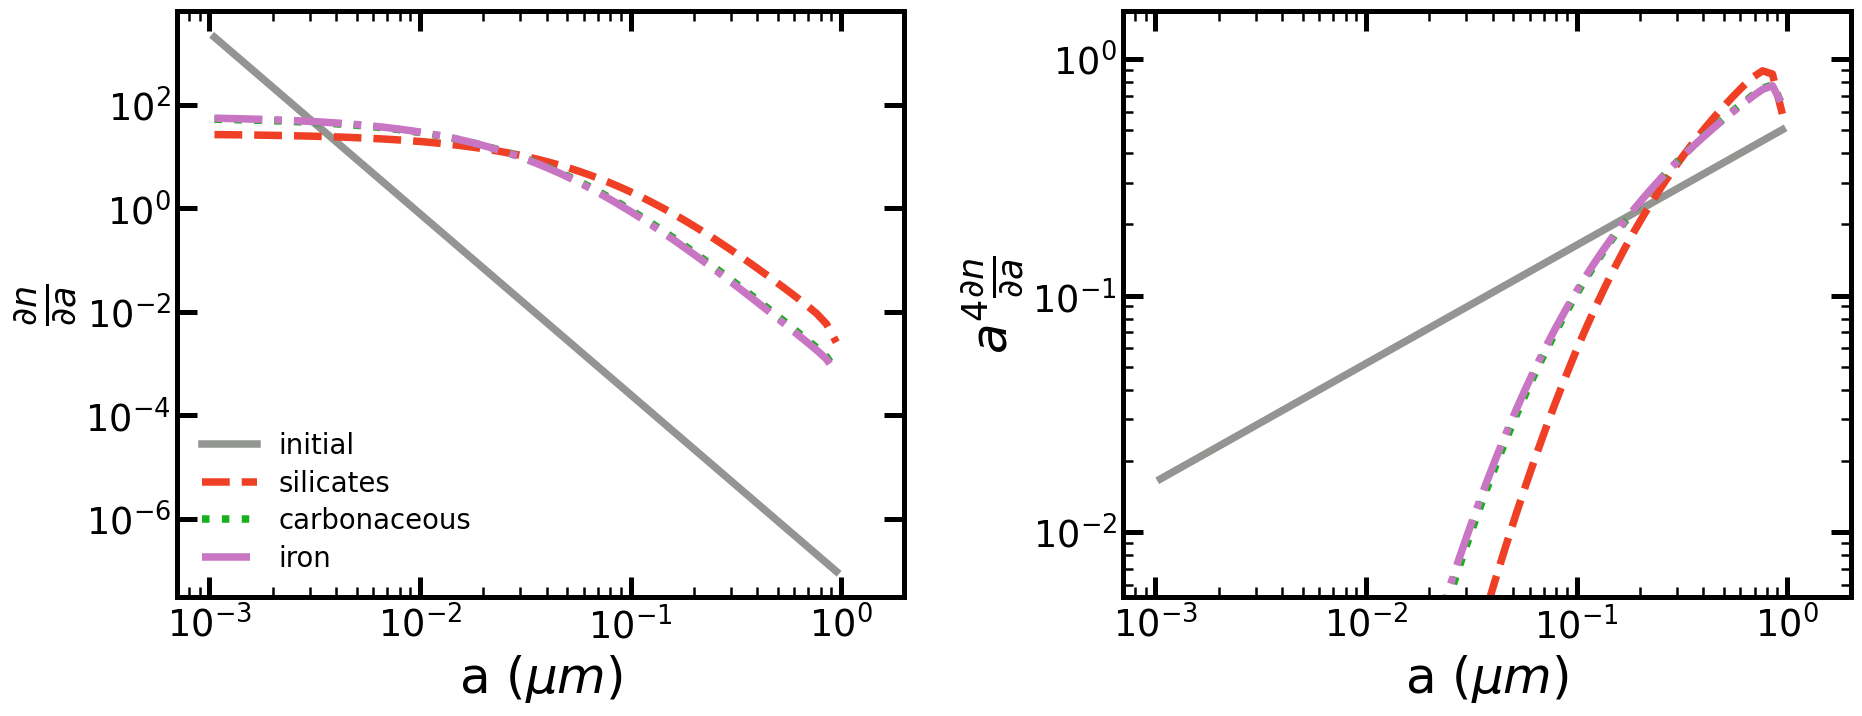

In [201]:
foutname = plot_dir+'analytical_sputtering_pred.pdf'

amin=1E-3; amax=1E0
init_dnda = gse.MRN_dnda
def init_dmda(a):
    return init_dnda(a) * 4 * np.pi / 3 * np.power(a,3)
def init_dmdloga(a):
    return init_dnda(a) * 4 * np.pi / 3 * np.power(a,4)
# Use this to normalize dn/da by total grain number and dm/da by total grain mass
init_dn_norm = 1/quad(init_dnda,amin,amax)[0]
init_dm_norm = 1/quad(init_dmda,amin,amax)[0]
bin_nums=64


fig = Figure(2,ncols=2)
colors = config.LINE_COLORS[:5]
linestyles = config.LINE_STYLES[:5]
linewidth = 2*config.BASE_LINEWIDTH
fig.set_axis(0, 'grain_size', 'dn/da',y_lim=[np.power(10,-0.5)*np.min(init_dnda(a_bins)[init_dnda(a_bins)>0]*init_dn_norm),np.power(10,0.5)*np.max(init_dnda(a_bins)[init_dnda(a_bins)>0]*init_dn_norm)])
fig.set_axis(1, 'grain_size', 'dm/da',y_lim=[np.power(10,-0.5)*np.min(init_dmdloga(a_bins)[init_dmdloga(a_bins)>0]*init_dm_norm),np.power(10,0.5)*np.max(init_dmdloga(a_bins)[init_dmdloga(a_bins)>0]*init_dm_norm)])


fig.plot_line_data(0,a_bins,init_dnda(a_bins)*init_dn_norm, color='xkcd:grey',linestyle=linestyles[0], linewidth=1.5*config.BASE_LINEWIDTH,label="initial", zorder=-2)
fig.plot_line_data(1,a_bins,init_dmdloga(a_bins)*init_dm_norm, color='xkcd:grey',linestyle=linestyles[0], linewidth=1.5*config.BASE_LINEWIDTH,label="initial", zorder=-2)

species = ['silicates','carbonaceous','iron']
ISM_phase = 'HIM'
dt = 0.1
init_depl = 0.1 # initial depletion of key element for dust species
subcycle_constraints='min_bin'

for i,spec in enumerate(species):
    print(spec)
    a_bins, dnda, dmda  = gse.change_in_grain_distribution_from_acc_sput(dt, amin=amin,amax=amax,bin_num=bin_nums, init_dnda = init_dnda, ISM_phase=ISM_phase, subcycle_constraints=subcycle_constraints, species=spec, depl_frac=init_depl)

    fig.plot_line_data(0,a_bins,dnda(a_bins), color=colors[i+1],linestyle=linestyles[i+1], linewidth=1.5*config.BASE_LINEWIDTH,label=spec)

    fig.plot_line_data(1,a_bins,dmdloga(a_bins), color=colors[i+1],linestyle=linestyles[i+1], linewidth=1.5*config.BASE_LINEWIDTH,label=spec)

fig.set_all_legends(max_cols=2,rescale_font=0.75)
fig.save(foutname)


#### Simple visualizations for dust processes diagram

This are parameters every diagram uses.

In [264]:
amin=1E-3; amax=1E0
init_dnda = gse.MRN_dnda
def init_dmda(a):
    return init_dnda(a) * 4 * np.pi / 3 * np.power(a,3)
def init_dmdloga(a):
    return init_dnda(a) * 4 * np.pi / 3 * np.power(a,4)
# Use this to normalize dn/da by total grain number and dm/da by total grain mass
init_dn_norm = 1/quad(init_dnda,amin,amax)[0]
init_dm_norm = 1/quad(init_dmda,amin,amax)[0]
bin_nums=64

colors = ["xkcd:dark royal blue","xkcd:forest green","xkcd:indian red",]
linestyles = config.LINE_STYLES[:5]
linewidth = 3.75*config.BASE_LINEWIDTH

species = ['silicates','carbonaceous','iron']
init_depl = 0.3 # initial depletion of key element for dust species


silicates
Clumping factor 3.7209810129834526
Predicted dadt (um/Gyr): 0.1702188521068979
Min bin width used for subcyling 0.00011397385999480242
Total cycles needed 50.0 Subcycle timestep 0.0002
Change in total grain number 0.9999999998465511
Change in total grain mass 1.3318645692103412
Initial and final depletion fraction 0.3 0.39955937076310244
carbonaceous
Clumping factor 3.3863283482060633
Predicted dadt (um/Gyr): 0.22871617118284024
Min bin width used for subcyling 0.00011397385999480242
Total cycles needed 67.0 Subcycle timestep 0.00014925373134328358
Change in total grain number 0.9999999998000392
Change in total grain mass 1.5054957508119744
Initial and final depletion fraction 0.3 0.45164872524359245
iron
Clumping factor 3.7209810129834526
Predicted dadt (um/Gyr): 0.018197970689643943
Min bin width used for subcyling 0.00011397385999480242
Total cycles needed 6.0 Subcycle timestep 0.0016666666666666668
Change in total grain number 0.9999999999826968
Change in total grain mass

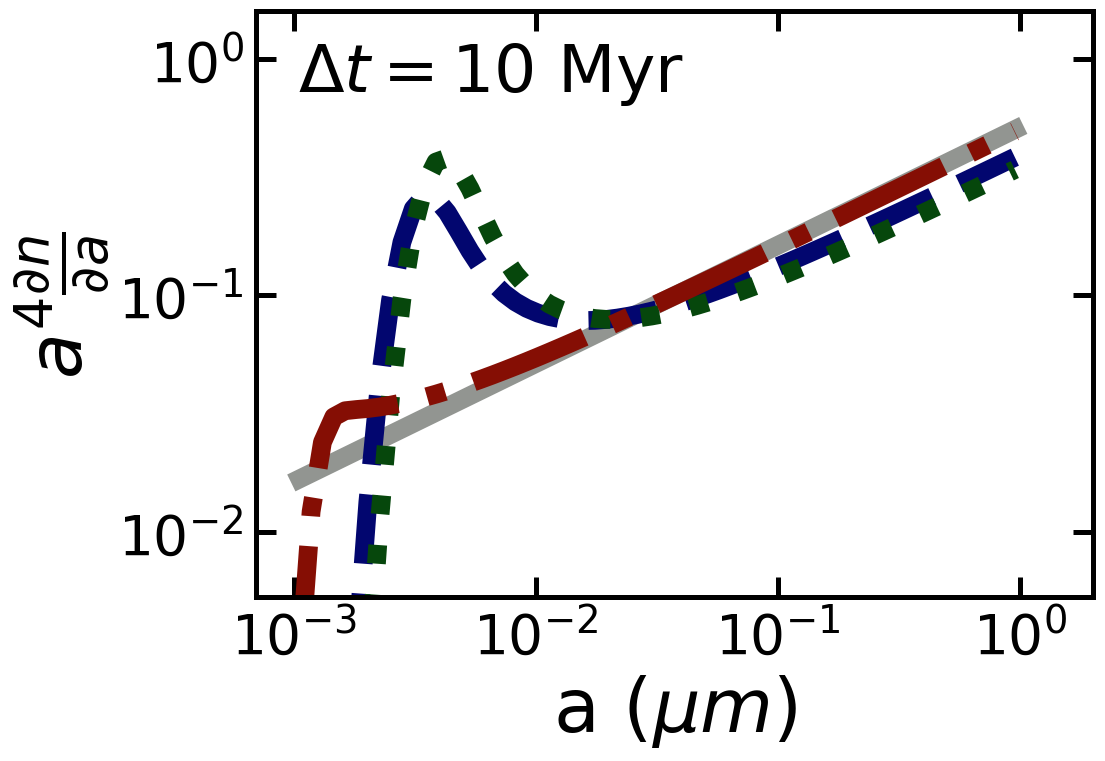

In [265]:
foutname = plot_dir+'grain_size_accretion_diagram.pdf'
ISM_phase = 'CNM'
dt = 0.01
subcycle_constraints='min_bin'


fig = Figure(1,ncols=2)

fig.set_axis(0, 'grain_size', 'dm/da',y_lim=[np.power(10,-0.5)*np.min(init_dmdloga(a_bins)[init_dmdloga(a_bins)>0]*init_dm_norm),np.power(10,0.5)*np.max(init_dmdloga(a_bins)[init_dmdloga(a_bins)>0]*init_dm_norm)], rescale_font=1.5, no_minor_ticks=True)

fig.plot_line_data(0,a_bins,init_dmdloga(a_bins)*init_dm_norm, color='xkcd:grey',linestyle=linestyles[0], linewidth=linewidth,label="initial", zorder=-2)

for i,spec in enumerate(species):
    print(spec)
    a_bins, dnda, dmda  = gse.change_in_grain_distribution_from_acc_sput(dt, amin=amin,amax=amax,bin_num=bin_nums, init_dnda = init_dnda, ISM_phase=ISM_phase, subcycle_constraints=subcycle_constraints, species=spec, depl_frac=init_depl)

    fig.plot_line_data(0,a_bins,dmdloga(a_bins), color=colors[i],linestyle=linestyles[i+1], linewidth=linewidth,label=spec)

text = r'$\Delta t = %2.0f $ Myr'%(dt*1E3)
fig.add_text(0,0.05,0.95,text,rescale_font=1, ha='left', va='top')

#fig.set_all_legends(max_cols=2,rescale_font=0.75)
fig.save(foutname)

silicates
Predicted dadt (um/Gyr): -0.9199920004722989
Min bin width used for subcyling 0.00011397385999480242
Total cycles needed 2691.0 Subcycle timestep 3.716090672612412e-05
Change in total grain number 1.5126259679420442e-05
Change in total grain mass 0.35256246297961885
Initial and final depletion fraction 0.1 0.035256246297961855
carbonaceous
Predicted dadt (um/Gyr): -0.45783220029913224
Min bin width used for subcyling 0.00011397385999480242
Total cycles needed 1339.0 Subcycle timestep 7.468259895444362e-05
Change in total grain number 8.428418972989833e-05
Change in total grain mass 0.5079015169690576
Initial and final depletion fraction 0.1 0.05079015169690579
iron
Predicted dadt (um/Gyr): -0.43646272260277963
Min bin width used for subcyling 0.00011397385999480242
Total cycles needed 1277.0 Subcycle timestep 7.830853563038371e-05
Change in total grain number 9.472373982720711e-05
Change in total grain mass 0.5178300341299557
Initial and final depletion fraction 0.1 0.0517830

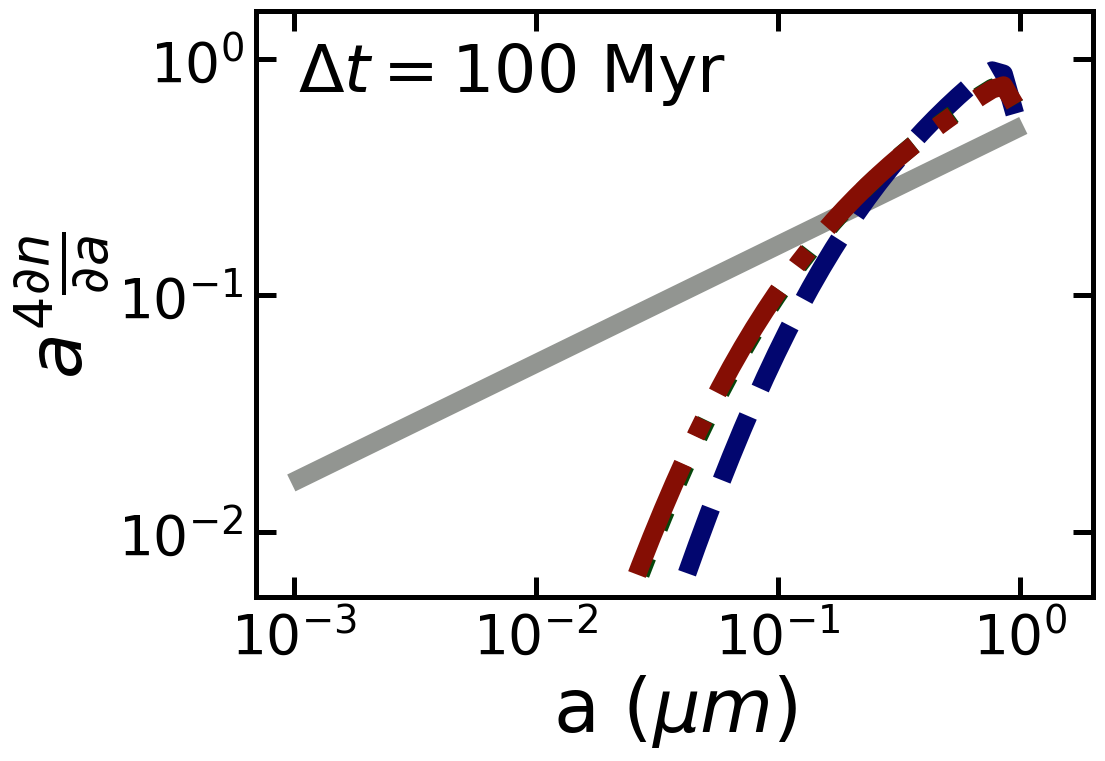

In [266]:
foutname = plot_dir+'grain_size_sputtering_diagram.pdf'

ISM_phase = 'HIM'
dt = 0.1
subcycle_constraints='min_bin'


fig = Figure(1,ncols=2)

fig.set_axis(0, 'grain_size', 'dm/da',y_lim=[np.power(10,-0.5)*np.min(init_dmdloga(a_bins)[init_dmdloga(a_bins)>0]*init_dm_norm),np.power(10,0.5)*np.max(init_dmdloga(a_bins)[init_dmdloga(a_bins)>0]*init_dm_norm)], rescale_font=1.5, no_minor_ticks=True)

fig.plot_line_data(0,a_bins,init_dmdloga(a_bins)*init_dm_norm, color='xkcd:grey',linestyle=linestyles[0], linewidth=linewidth,label="initial", zorder=-2)

for i,spec in enumerate(species):
    print(spec)
    a_bins, dnda, dmda  = gse.change_in_grain_distribution_from_acc_sput(dt, amin=amin,amax=amax,bin_num=bin_nums, init_dnda = init_dnda, ISM_phase=ISM_phase, subcycle_constraints=subcycle_constraints, species=spec, depl_frac=init_depl)

    fig.plot_line_data(0,a_bins,dmdloga(a_bins), color=colors[i],linestyle=linestyles[i+1], linewidth=linewidth,label=spec)

text = r'$\Delta t = %3.0f $ Myr'%(dt*1E3)
fig.add_text(0,0.05,0.95,text,rescale_font=1, ha='left', va='top')

#fig.set_all_legends(max_cols=2,rescale_font=0.75)
fig.save(foutname)


In [ ]:
foutname = plot_dir+'grain_size_shattering_diagram.pdf'

ISM_phase = 'WIM'
dt = 0.02
subcycle_constraints='both'


fig = Figure(1,ncols=2)

fig.set_axis(0, 'grain_size', 'dm/da',y_lim=[np.power(10,-0.5)*np.min(init_dmdloga(a_bins)[init_dmdloga(a_bins)>0]*init_dm_norm),np.power(10,0.5)*np.max(init_dmdloga(a_bins)[init_dmdloga(a_bins)>0]*init_dm_norm)], rescale_font=1.5, no_minor_ticks=True)

fig.plot_line_data(0,a_bins,init_dmdloga(a_bins)*init_dm_norm, color='xkcd:grey',linestyle=linestyles[0], linewidth=linewidth,label="initial", zorder=-2)

for i,spec in enumerate(species):
    print(spec)
    a_bins, dnda, dmda  = gse.change_in_grain_distribution_from_shat_coag(dt, amin=amin,amax=amax,bin_num=bin_nums, init_dnda = init_dnda, ISM_phase=ISM_phase, subcycle_constraints=subcycle_constraints, species=spec, depl_frac=init_depl)

    fig.plot_line_data(0,a_bins,dmdloga(a_bins), color=colors[i],linestyle=linestyles[i+1], linewidth=linewidth,label=spec)

text = r'$\Delta t = %3.0f $ Myr'%(dt*1E3)
fig.add_text(0,0.05,0.95,text,rescale_font=1, ha='left', va='top')

#fig.set_all_legends(max_cols=2,rescale_font=0.75)
fig.save(foutname)


## Sub-Resolved Gas Clumping

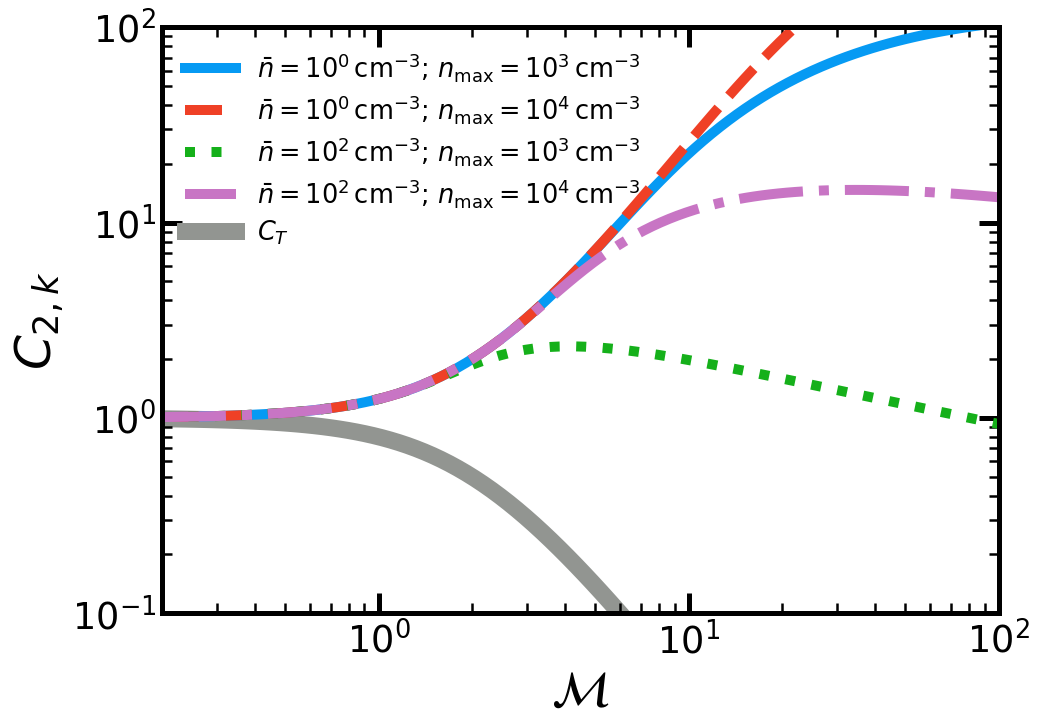

In [ ]:
from scipy.special import erfc,erf

foutname = 'clumping_factor.pdf'

M_limits = [0.2,100]
C_limits = [0.1,100]
nmaxs = [1E3,1E4,1E3,1E4]
ns=[1E0,1E0,1E2,1E2]


M = np.logspace(np.log10(M_limits[0]),np.log10(M_limits[1]),100)
b = 0.5 # ratio of solenoidal to compressive turbulence
sigma = np.sqrt(np.log(1+b*b*M*M))

N = len(nmaxs)

colors = config.LINE_COLORS[:N]
linestyles = config.LINE_STYLES[:N]
linewidth = 2*config.BASE_LINEWIDTH

x_label = r'$\mathcal{M}$'
y_label = r'$C_{2,k}$'
fig = Figure(1)
fig.set_axis(0, 'M', 'clumping_factor', x_lim=M_limits, x_log=True, x_label=x_label, y_label=y_label, y_lim=C_limits, y_log=True)



for i in range(N):
    nmax=nmaxs[i]
    n=ns[i]
    clumping_factor = np.exp(sigma*sigma)/2 * erfc((3/2*sigma*sigma-np.log(nmax/n)) / (np.sqrt(2)*sigma))
    label = r'$\bar{n}=10^{%i}\,{\rm cm^{-3}}$; $ n_{\rm max}=10^{%i}\,{\rm cm^{-3}}$'%(np.log10(n),np.log10(nmax))
    fig.plot_line_data(0,M,clumping_factor,label=label,linestyle=linestyles[i],color=colors[i], linewidth=linewidth)
    
    if i == N-1:
        T_clumping_factor = 1/(np.exp(sigma*sigma)/2 * (1 + erf((3/2*sigma*sigma + np.log(nmax/n)) / (np.sqrt(2)*sigma))))
        label = r'$C_T$'
        fig.plot_line_data(0,M,T_clumping_factor,label=label,linestyle='-',color='xkcd:grey', linewidth=1.7*linewidth,zorder=-3)

fig.set_all_legends(rescale_font=0.7,max_cols=1)

fig.save(plot_dir+foutname)

## Turbulence Driven Grain Velocity

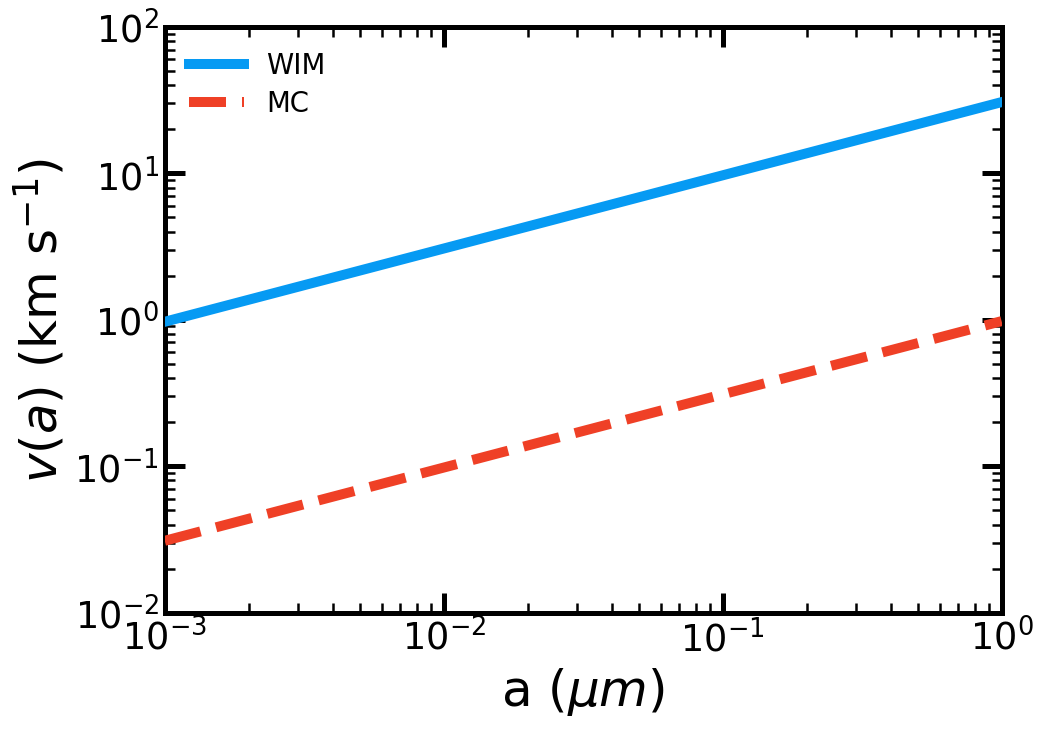

In [ ]:
foutname = 'grain_velocity.pdf'

a = np.logspace(-3,0) # micron
Ms = [3.3,3.3] # Mach number
nHs = [0.1,300] # cm^-3
rho_grs = [2.5,2.5] # g cm^-3
Ts = [8000,25]# Kelvin

labels = ['WIM', 'MC']

x_limits = [np.min(a),np.max(a)]
y_limits = [1E-2,1E2]

N=len(Ms)

colors = config.LINE_COLORS[:N]
linestyles = config.LINE_STYLES[:N]
linewidth = 2*config.BASE_LINEWIDTH

x_label = r'a ($\mu m$)'
y_label = r'$v(a)$ (km s$^{-1}$)'
fig = Figure(1)
fig.set_axis(0, 'M', 'clumping_factor', x_lim=x_limits, x_log=True, x_label=x_label, y_label=y_label, y_lim=y_limits, y_log=True)

for i in range(N):
    M=Ms[i]; nH=nHs[i];rho_gr=rho_grs[i];T=Ts[i]
    v_grain = 1.1 * np.power(M,3/2) * np.power(a/0.1,1/2) * np.power(T/1E4,1/4) * np.power(nH/1,-1/4)* np.power(rho_gr/3.5, 1/2.5)
    label = 'Hirashita+19'
    fig.plot_line_data(0,a,v_grain,label=labels[i],linestyle=linestyles[i],color=colors[i], linewidth=linewidth)
    # v_disp = 1.1 * np.power(M,3/2) * np.power(a/0.1,1/2) * np.power(T/1E4,1/4) * np.power(nH/1,-1/4)* np.power(rho_gr/3.5, 1/2.5)
    # label = 'Li+21'
    # fig.plot_line_data(0,a,v_grain,label=label,linestyle=linestyles[i],color=colors[i], linewidth=linewidth)
    fig.set_all_legends(fontsize=0.75*config.SMALL_FONT)

fig.save(plot_dir+foutname)

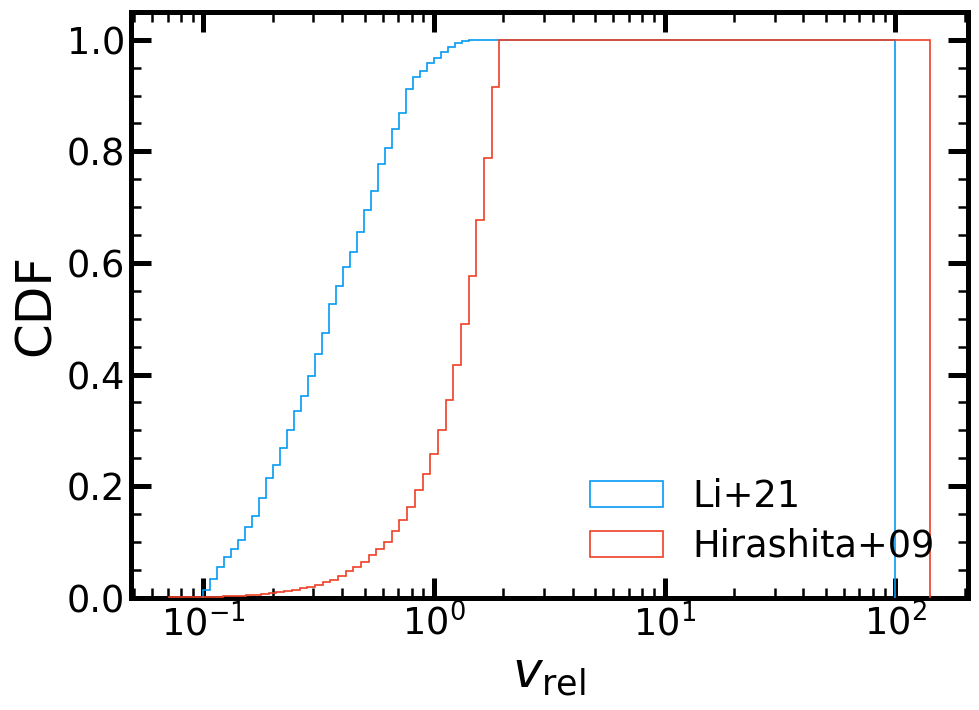

In [ ]:
v1 = 1
v2 = 1

N=10000


xlim= [0.1,100]
ylim = [0,1]

colors = config.LINE_COLORS[:2]
linestyles = config.LINE_STYLES[:2]
linewidth = 2*config.BASE_LINEWIDTH

labels = ['Li+21','Hirashita+09']

y_label = 'CDF'
x_label = r'$v_{\rm rel}$'
fig = Figure(1)
fig.set_axis(0, 'vrel', 'prob', x_lim=xlim, x_log=True, x_label=x_label, y_label=y_label, y_lim=ylim, y_log=False)

# Determine relative velocities by taking the difference of x, y, and z components
vrel = np.zeros(N)
for i in range(3):
    v1i=np.random.normal(0,v1*v1/3,1000)
    v2i=np.random.normal(0,v2*v2/3,1000)
    vrel = np.power(v1i-v2i,2)
vrel=np.sqrt(vrel)

#fig.plot_1Dhistogram(0,vrel,bin_log=True)
fig.plot_1Dhistogram(0,vrel,bin_log=True,cumulative=True,label=labels[0])


impact_angle = np.random.uniform(-1,1,N)
vrel = np.sqrt(v1*v1 + v2*v2 - 2*v1*v2*impact_angle)
fig.plot_1Dhistogram(0,vrel,bin_log=True,cumulative=True,label=labels[1])

fig.set_all_legends()



## Coagulation Velocity

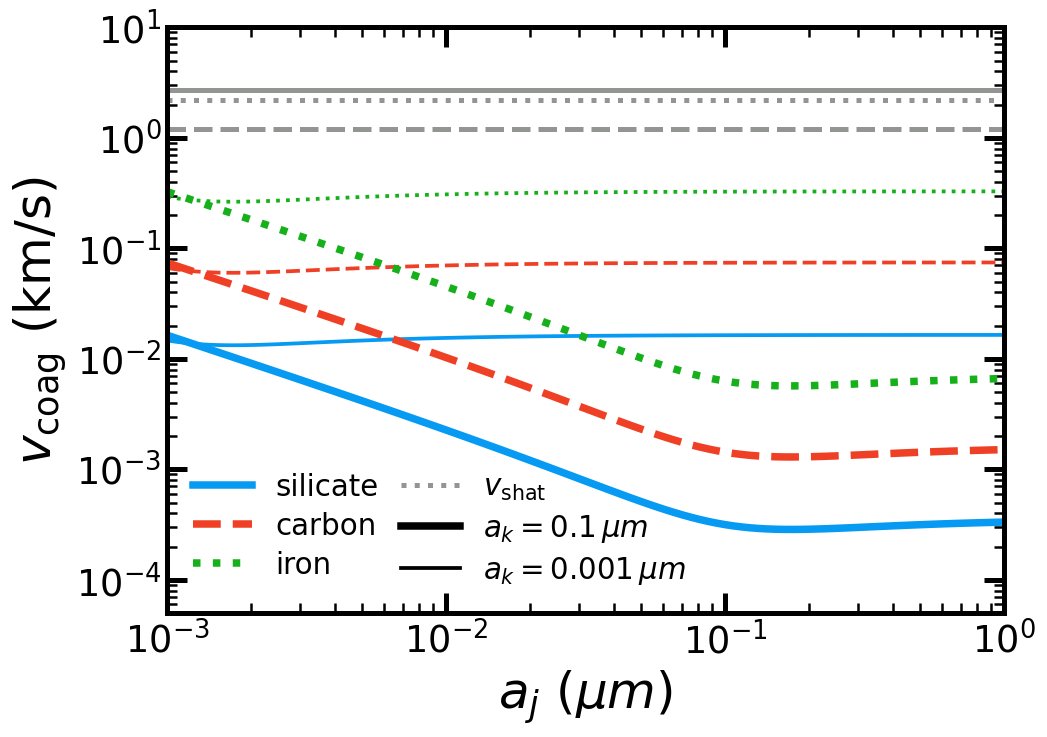

In [ ]:
foutname=plot_dir+'coagulation_velocity.pdf'

gammas = [25,75,3000]
Es = [5.4E11,1E11,2.1E12]
nus = [0.17,0.32,0.27]
rho_grs = [3.13,2.25,7.86] # g cm^-3
aks = [0.1,0.001]
vshats = [2.7,1.2,2.2]
species = ['silicate','carbon','iron']

xlim= [0.001,1]
ylim = [5E-5,1E1]

colors = config.LINE_COLORS[:3]
linestyles = config.LINE_STYLES[:3]
linewidth = config.LINE_WIDTHS[[0,3]]


y_label = r'$v_{\rm coag}$ (km/s)'
x_label = r'$a_j$ ($\mu m$)'

fig = Figure(1)
fig.set_axis(0, 'vcoag', 'aj', x_lim=xlim, x_log=True, x_label=x_label, y_label=y_label, y_lim=ylim, y_log=True)


for i in range(len(species)):
    gamma = gammas[i]; E = Es[i]; nu = nus[i]; rho_gr = rho_grs[i]
    Eratio = 1/(2*np.power(1-nu,2)/E)

    for j, ak in enumerate(aks):
        if j  == 0:
            #label = species[i] + r' $a_k=%.3f \, \mu m$'%ak
            label = species[i]
        else:
            label = None
        aj = np.logspace(np.log10(xlim[0]),np.log10(xlim[1]),100)*1E-4
        ak*=1E-4
        
        Rkj = ak*aj/(aj+ak);
        vcoag = 2.14E-5*np.sqrt((np.power(aj,3) + np.power(ak,3))/np.power(aj + ak,3))*np.power(gamma,5/6)/(np.power(Eratio,1/3)*np.sqrt(rho_gr)*np.power(Rkj,5/6)) # km/s

        fig.plot_line_data(0,aj/1E-4,vcoag,label=label,linestyle=linestyles[i],color=colors[i], linewidth=linewidth[j])

        if j==0:
            if i == len(species)-1: vshat_label=r'$v_{\rm shat}$'
            else: vshat_label=None
            vshat = mlines.Line2D(xlim,[vshats[i],vshats[i]], c='xkcd:grey',label=vshat_label,linewidth=config.BASE_LINEWIDTH,linestyle=linestyles[i],zorder=-3)
            fig.add_artist(0,vshat)
        
        if i == len(species)-1:
            new_label=r'$a_k=%g \, \mu m$'%(ak*1E4)
            fig.plot_line_data(0,[config.EPSILON],[config.EPSILON],label=new_label,linestyle='-',color='xkcd:black', linewidth=linewidth[j])



fig.set_all_legends(fontsize=config.SMALL_FONT/1.25,ncols=2,loc='lower left')

fig.save(foutname)

# Analytical Testing

## SNe Dust Destruction

### Sputtering and shattering efficiency functions

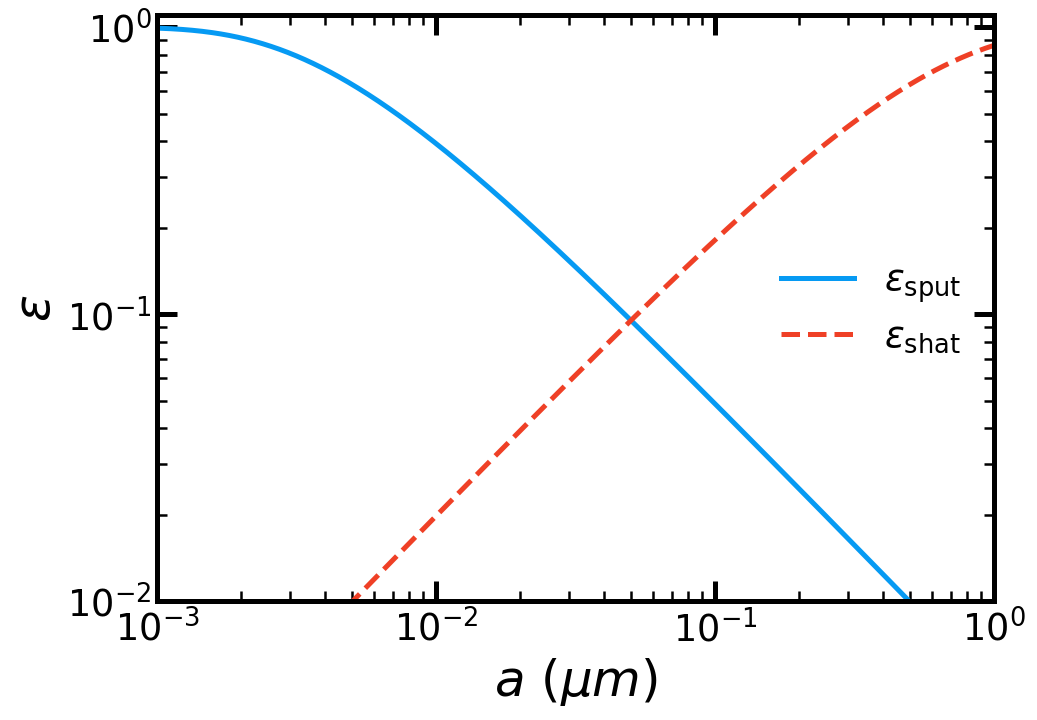

In [ ]:
a_sput = 0.05; # microns
a_shat = 0.05;
delta_sput = 0.1;
delta_shat = 0.1;
a_limit = [1E-3,1E0]
a = np.logspace(np.log10(a_limit[0]),np.log10(a_limit[1]),500)


y_label = r'$ \epsilon $'
x_label = r'$a$ ($\mu m$)'
eff_limits = [1E-2,1.1]
fig = Figure(1)
fig.set_axis(0, 'a', 'eff', x_lim=a_limit, x_log=True, x_label=x_label, y_label=y_label, y_lim=eff_limits, y_log=True)


def eff_sput(a):
        return (1 - np.exp(-(delta_sput / (a/a_sput))))
def eff_shat(a):
        return (1 - np.exp(-(delta_shat * (a/a_shat))))

i=0
fig.plot_line_data(0,a,eff_sput(a),label=r'$\epsilon_{\rm sput}$',color=colors[i], linestyle=linestyles[i])
i=1
fig.plot_line_data(0,a,eff_shat(a),label=r'$\epsilon_{\rm shat}$',color=colors[i], linestyle=linestyles[i])
fig.set_all_legends()

### Sputtering and shattering routines

In [ ]:
from scipy.interpolate import CubicSpline
from scipy.integrate import quad

# Define the initial dnda you want to assume (MRN for typical ISM dust or log normal for stardust are good choices)
def MRN_dnda(a):
    return np.power(a,-3.5)
def MRN_dmda(a):
    return a*a*a*MRN_dnda(a)
    
def lognorm_dnda(a):
    a_SNe = 0.1
    sigma_SNe = 0.2
    return 1/a * np.exp(-np.power(np.log(a/a_SNe),2) / (2*sigma_SNe*sigma_SNe))
def lognorm_dmda(a):
    return a*a*a*lognorm_dnda(a)



# Returns the resulting dnda after a sputtering step given an initial dnda
def dnda_sput(dnda, a, delta_sput=0.1, a_sput=0.1):
    def eff_sput(a, delta_sput, a_sput):
        return (1 - np.exp(-(delta_sput / (a/a_sput))))
    return dnda(a)*(1-eff_sput(a,delta_sput,a_sput))
# Returns the resulting dmda after a sputtering step given an initial dnda
def dmda_sput(dnda, a, delta_sput=0.1, a_sput=0.1):
    return a*a*a*dnda_sput(dnda, a, delta_sput, a_sput)

# Returns the resulting dnda after a shattering step given an initial dnda
def dnda_after_shat(dnda, a, a_limit, delta_shat=0.1, a_shat=0.1, a_frag_max=0.1):
    def eff_shat(a, delta_shat, a_shat):
        return (1 - np.exp(-(delta_shat * (a/a_shat))))
    def dmda_shattered(a, dnda):
        return eff_shat(a, delta_shat, a_shat) * dnda(a) * a * a * a
    def dnda_fragments(a, C_frag):
        return np.piecewise(a, [a <= a_frag_max, a > a_frag_max], [lambda a: C_frag * np.power(a,-3.3), 0])

    M_shattered = quad(dmda_shattered, a_limit[0], a_limit[1], args=(dnda))[0]
    C_frag = M_shattered * 7 / (10 * (np.power(a_frag_max,0.7) - np.power(a_limit[0],0.7)))
    return dnda_fragments(a, C_frag) + dnda(a)*(1-eff_shat(a, delta_shat, a_shat))
# Returns the resulting dmda after a shattering step given an initial dnda
def dmda_after_shat(dnda, a, a_limit, delta_shat=0.1, a_shat=0.1, a_frag_max=0.1):
    return a*a*a*dnda_after_shat(dnda, a, a_limit, delta_shat, a_shat, a_frag_max)



def shat_sput_shat(init_dnda, init_dmda, delta_sput, delta_shat, a_sput, a_shat, a_frag_max, a_limit):

    initial_mass = quad(init_dmda, a_limit[0], a_limit[1])[0]
    dmda_shat1 = dmda_after_shat(init_dnda,a,a_limit,delta_shat=delta_shat,a_shat=a_shat,a_frag_max=a_frag_max)
    dnda_shat1 = dnda_after_shat(init_dnda,a,a_limit,delta_shat=delta_shat,a_shat=a_shat,a_frag_max=a_frag_max)
    dmda_shat1 = CubicSpline(a,dmda_shat1); dnda_shat1 = CubicSpline(a,dnda_shat1); 
    shat1_mass = quad(dmda_shat1, a_limit[0], a_limit[1])[0]
    
    dmda_sput1 = dmda_sput(dnda_shat1,a,delta_sput=delta_sput,a_sput=a_sput)
    dnda_sput1 = dnda_sput(dnda_shat1,a,delta_sput=delta_sput,a_sput=a_sput)
    dmda_sput1 = CubicSpline(a,dmda_sput1); dnda_sput1 = CubicSpline(a,dnda_sput1); 
    sput1_mass = quad(dmda_sput1, a_limit[0], a_limit[1])[0]
    
    dmda_shat2 = dmda_after_shat(dnda_sput1,a,a_limit,delta_shat=delta_shat,a_shat=a_shat,a_frag_max=a_frag_max)
    dnda_shat2 = dnda_after_shat(dnda_sput1,a,a_limit,delta_shat=delta_shat,a_shat=a_shat,a_frag_max=a_frag_max)
    dmda_shat2 = CubicSpline(a,dmda_shat2); dnda_shat2 = CubicSpline(a,dnda_shat2); 
    shat2_mass = quad(dmda_shat2, a_limit[0], a_limit[1])[0]
    
    final_mass = shat2_mass
    final_dnda = dnda_shat2
    final_dmda = dmda_shat2
    dest_frac = 1-final_mass/initial_mass
    

    return dest_frac, final_dnda, final_dmda


def sput_shat(init_dnda, init_dmda, delta_sput, delta_shat, a_sput, a_shat, a_frag_max, a_limit):

    initial_mass = quad(init_dmda, a_limit[0], a_limit[1])[0]

    dmda_sput1 = dmda_sput(init_dnda,a,delta_sput=delta_sput,a_sput=a_sput)
    dnda_sput1 = dnda_sput(init_dnda,a,delta_sput=delta_sput,a_sput=a_sput)
    dmda_sput1 = CubicSpline(a,dmda_sput1); dnda_sput1 = CubicSpline(a,dnda_sput1); 
    sput1_mass = quad(dmda_sput1, a_limit[0], a_limit[1])[0]
    
    dmda_shat1 = dmda_after_shat(dnda_sput1,a,a_limit,delta_shat=delta_shat,a_shat=a_shat,a_frag_max=a_frag_max)
    dnda_shat1 = dnda_after_shat(dnda_sput1,a,a_limit,delta_shat=delta_shat,a_shat=a_shat,a_frag_max=a_frag_max)
    dmda_shat1 = CubicSpline(a,dmda_shat1); dnda_shat1 = CubicSpline(a,dnda_shat1); 
    shat1_mass = quad(dmda_shat1, a_limit[0], a_limit[1])[0]
    
    final_mass = shat1_mass
    final_dnda = dnda_shat1
    final_dmda = dmda_shat1
    dest_frac = 1-final_mass/initial_mass
    

    return dest_frac, final_dnda, final_dmda


def sput_only(init_dnda, init_dmda, delta_sput, a_sput, a_limit):

    initial_mass = quad(init_dmda, a_limit[0], a_limit[1])[0]

    dmda_sput1 = dmda_sput(init_dnda,a,delta_sput=delta_sput,a_sput=a_sput)
    dnda_sput1 = dnda_sput(init_dnda,a,delta_sput=delta_sput,a_sput=a_sput)
    dmda_sput1 = CubicSpline(a,dmda_sput1); dnda_sput1 = CubicSpline(a,dnda_sput1); 
    sput1_mass = quad(dmda_sput1, a_limit[0], a_limit[1])[0]
    
    
    final_mass = sput1_mass
    final_dnda = dnda_sput1
    final_dmda = dmda_sput1
    dest_frac = 1-final_mass/initial_mass
    

    return dest_frac, final_dnda, final_dmda



### Total dust destruction fraction
This tests the shattering+sputtering and shattering+sputting+shattering routines for varying sputtering and shattering efficiencies

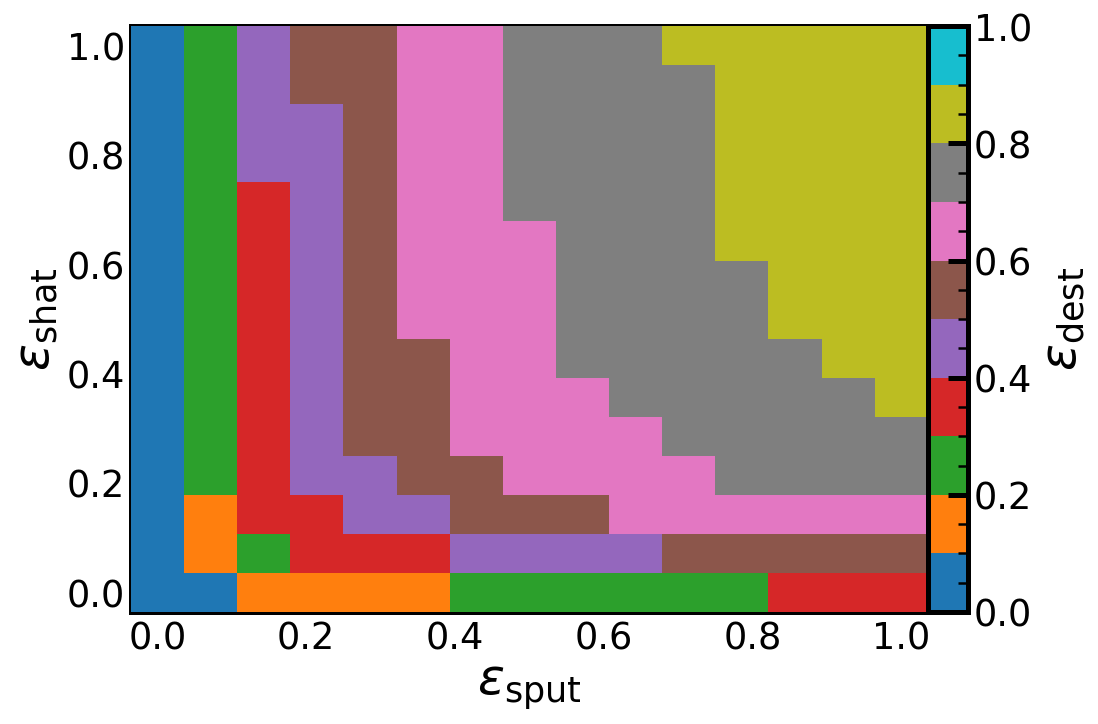

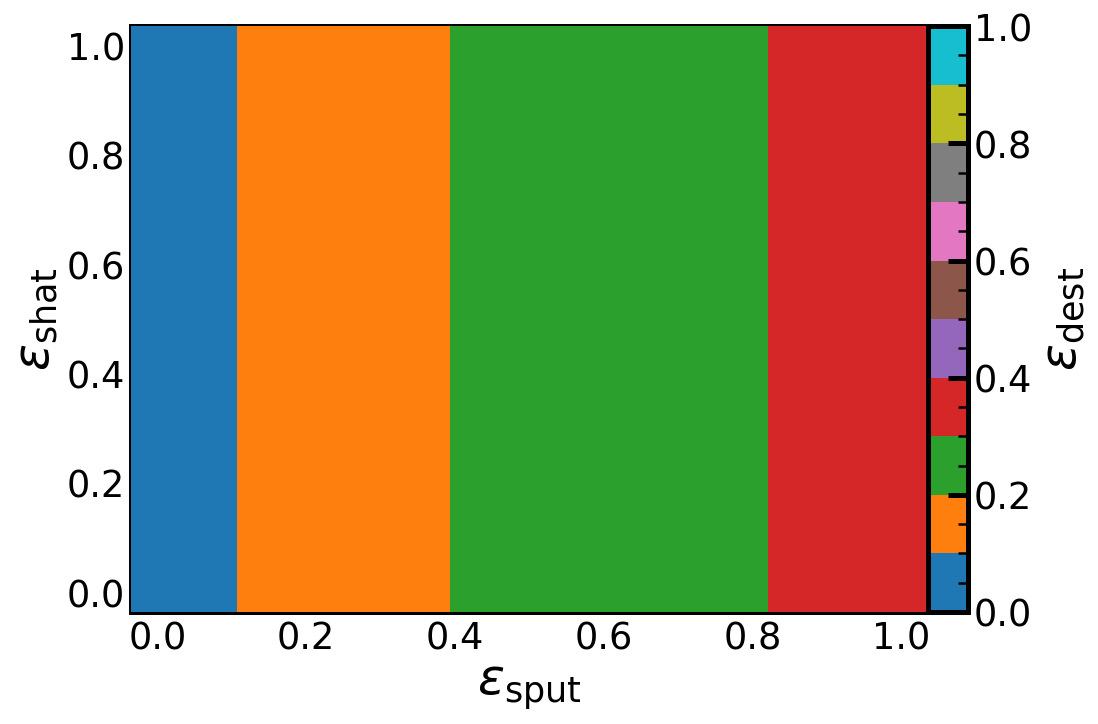

In [ ]:
# Set limits for size distribution
a_limit = [1E-3,1E0]
a = np.logspace(np.log10(a_limit[0]),np.log10(a_limit[1]),500)

a_sput = 0.05; # microns
a_shat = 0.05;
a_frag_max = a_shat


N=15
eff_shats = np.linspace(0,1,N)
eff_sputs = eff_shats
f_dest = np.zeros((N,N))

color_N = 5
colors = config.LINE_COLORS[:color_N]
linestyles = config.LINE_STYLES[:color_N]
linewidths = config.LINE_WIDTHS[[0,color_N]]

fig = Figure(1)
x_label = r'$\epsilon_{\rm sput}$'
y_label = r'$\epsilon_{\rm shat}$'
fig.set_axis(0, 'sput', 'shat', x_lim=[0,1], x_log=False, x_label=x_label, y_label=y_label, y_lim=[0,1], y_log=False)

for i,eff_sh in enumerate(eff_shats):
    for j,eff_sp in enumerate(eff_sputs):
        f_dest[i,j],_,_= shat_sput_shat(MRN_dnda, MRN_dmda, eff_sp,eff_sh, a_sput, a_shat, a_frag_max, a_limit)

fig.plot_2Dhistogram(0, 'M_survival', eff_sputs, eff_shats, f_dest, cmap='tab10', z_lim=[0,1], z_log=False,rescale_font=1)
fig.add_colorbar(0, cbar_label=r'$\epsilon_{\rm dest}$', invert_axis=False, no_minor_ticks=False, side='right', rescale_font=1,)

fig = Figure(1)
x_label = r'$\epsilon_{\rm sput}$'
y_label = r'$\epsilon_{\rm shat}$'
fig.set_axis(0, 'sput', 'shat', x_lim=[0,1], x_log=False, x_label=x_label, y_label=y_label, y_lim=[0,1], y_log=False)

for i,eff_sh in enumerate(eff_shats):
    for j,eff_sp in enumerate(eff_sputs):
        f_dest[i,j],_,_= sput_shat(MRN_dnda, MRN_dmda, eff_sp,eff_sh, a_sput, a_shat, a_frag_max, a_limit)

fig.plot_2Dhistogram(0, 'M_survival', eff_sputs, eff_shats, f_dest, cmap='tab10', z_lim=[0,1], z_log=False,rescale_font=1)
fig.add_colorbar(0, cbar_label=r'$\epsilon_{\rm dest}$', invert_axis=False, no_minor_ticks=False, side='right', rescale_font=1,)


### Resulting grain size distribution for my SNe models

Initial MRN
Sh+Sp+Sh Dest Frac: 0.3957291098021066
Sp+Sh Dest Frac: 0.14061929074583646
Initial Lognorm
Sh+Sp+Sh Dest Frac: 0.23183085769817413
Sp+Sh Dest Frac: 0.08669136017516244


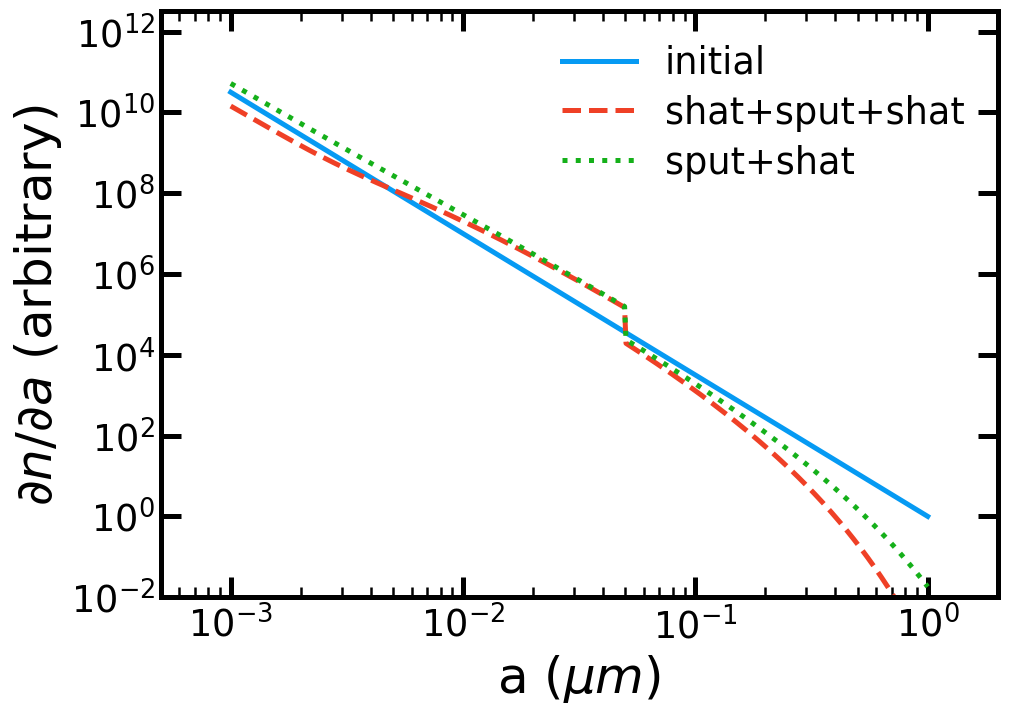

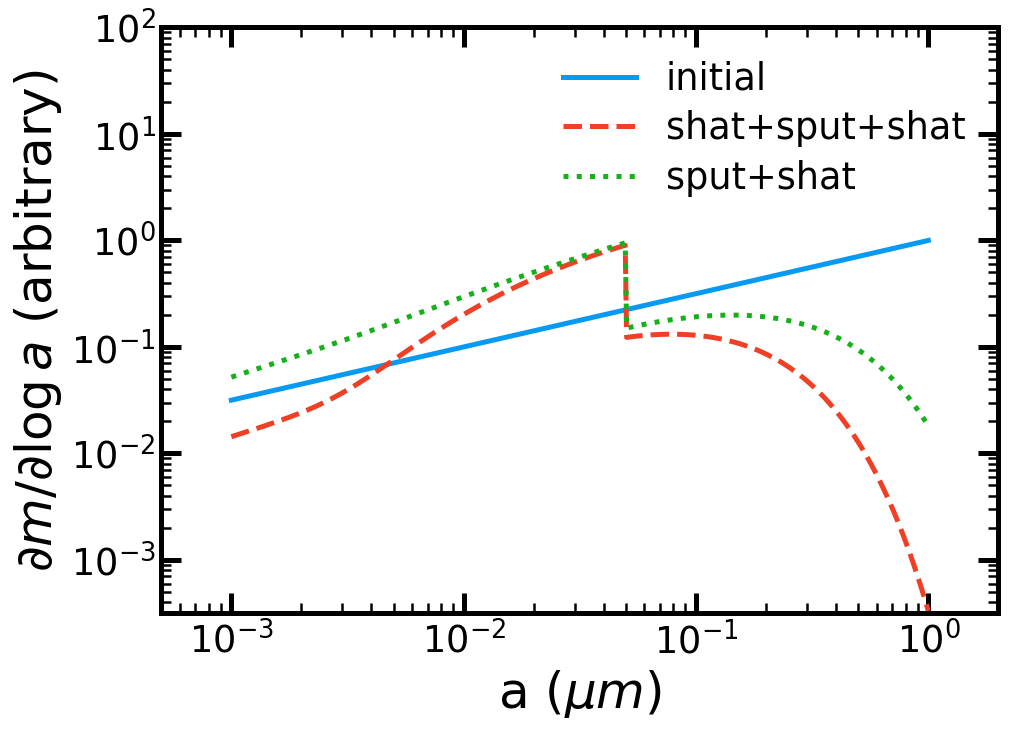

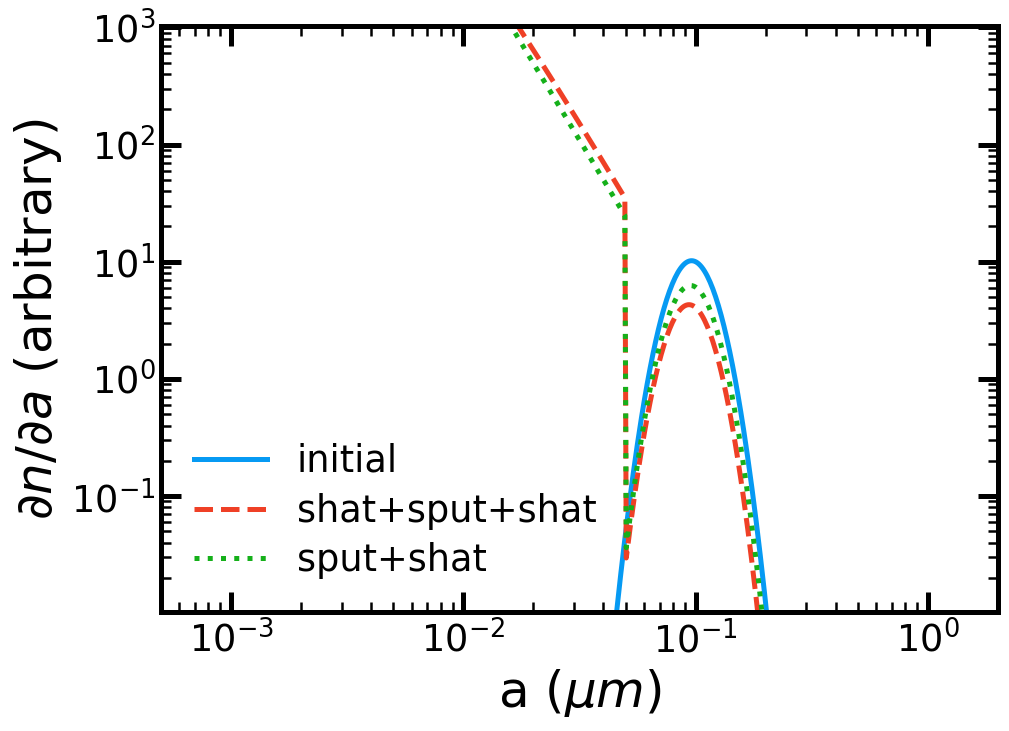

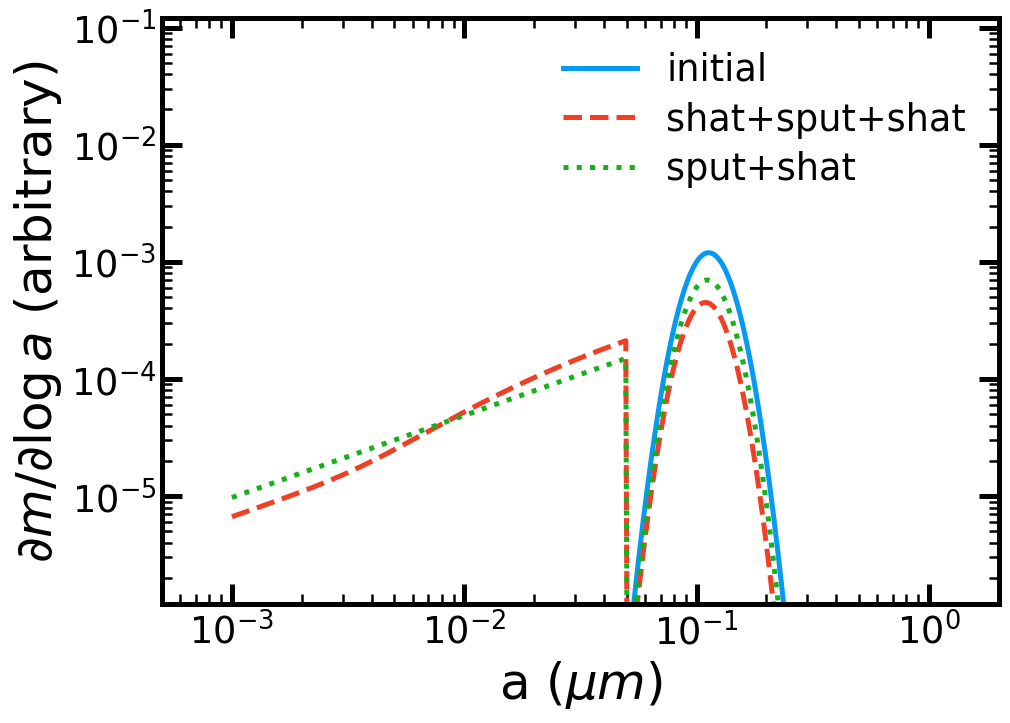

In [ ]:
# Set limits for size distribution
a_limit = [1E-3,1E0]
#a_limit = [4E-3,0.3]

a = np.logspace(np.log10(a_limit[0]),np.log10(a_limit[1]),500)

a_sput = 0.05; # microns
a_shat = 0.05;
delta_sput = 0.2;
delta_shat = 0.2;
a_frag_max = a_shat

initial_dnda=MRN_dnda
initial_dmda=MRN_dmda

f_shspsh,dnda_shspsh,dmda_shspsh = shat_sput_shat(initial_dnda, initial_dmda, delta_sput,delta_shat, a_sput, a_shat, a_frag_max, a_limit)

f_spsh,dnda_spsh,dmda_spsh = sput_shat(initial_dnda, initial_dmda, delta_sput,delta_shat, a_sput, a_shat, a_frag_max, a_limit)

print("Initial MRN")
print("Sh+Sp+Sh Dest Frac:",f_shspsh)
print("Sp+Sh Dest Frac:",f_spsh)
y_limit = [np.min(initial_dnda(a))*1E-2,np.max(initial_dnda(a))*1E2]
x_limit=[a_limit[0]*0.5,a_limit[1]*2]
x_label = r'a ($\mu m$)'
y_label = r'$\partial n/\partial a$ (arbitrary)'
fig = Figure(1)
fig.set_axis(0, 'a', 'number_survival_frac', x_lim=x_limit, x_log=True, x_label=x_label, y_label=y_label, y_lim=y_limit, y_log=True)

i=0
fig.plot_line_data(0,a,initial_dnda(a),label='initial',color=colors[i], linestyle=linestyles[i])
i=1
fig.plot_line_data(0,a,dnda_shspsh(a),label='shat+sput+shat',color=colors[i], linestyle=linestyles[i])
i=2
fig.plot_line_data(0,a,dnda_spsh(a),label='sput+shat',color=colors[i], linestyle=linestyles[i])
fig.set_all_legends()


y_limit = [np.min(dmda(a)*a)*1E-2,np.max(dmda(a)*a)*1E2]
x_limit=[a_limit[0]*0.5,a_limit[1]*2]
y_label = r'$\partial m/\partial \log a$ (arbitrary)'
fig = Figure(1)
fig.set_axis(0, 'a', 'number_survival_frac', x_lim=x_limit, x_log=True, x_label=x_label, y_label=y_label, y_lim=y_limit, y_log=True)

i=0
fig.plot_line_data(0,a,initial_dmda(a)*a,label='initial',color=colors[i], linestyle=linestyles[i])
i=1
fig.plot_line_data(0,a,dmda_shspsh(a)*a,label='shat+sput+shat',color=colors[i], linestyle=linestyles[i])
i=2
fig.plot_line_data(0,a,dmda_spsh(a)*a,label='sput+shat',color=colors[i], linestyle=linestyles[i])

fig.set_all_legends()


initial_dnda=lognorm_dnda
initial_dmda=lognorm_dmda


f_shspsh,dnda_shspsh,dmda_shspsh = shat_sput_shat(initial_dnda, initial_dmda, delta_sput,delta_shat, a_sput, a_shat, a_frag_max, a_limit)

f_spsh,dnda_spsh,dmda_spsh = sput_shat(initial_dnda, initial_dmda, delta_sput,delta_shat, a_sput, a_shat, a_frag_max, a_limit)

print("Initial Lognorm")
print("Sh+Sp+Sh Dest Frac:",f_shspsh)
print("Sp+Sh Dest Frac:",f_spsh)

y_limit = [np.max(initial_dnda(a))*1E-3,np.max(initial_dnda(a))*1E2]
x_limit=[a_limit[0]*0.5,a_limit[1]*2]
y_label = r'$\partial n/\partial a$ (arbitrary)'
fig = Figure(1)
fig.set_axis(0, 'a', 'number_survival_frac', x_lim=x_limit, x_log=True, x_label=x_label, y_label=y_label, y_lim=y_limit, y_log=True)

i=0
fig.plot_line_data(0,a,initial_dnda(a),label='initial',color=colors[i], linestyle=linestyles[i])
i=1
fig.plot_line_data(0,a,dnda_shspsh(a),label='shat+sput+shat',color=colors[i], linestyle=linestyles[i])
i=2
fig.plot_line_data(0,a,dnda_spsh(a),label='sput+shat',color=colors[i], linestyle=linestyles[i])
fig.set_all_legends()


y_limit = [np.max(initial_dmda(a)*a)*1E-3,np.max(initial_dmda(a)*a)*1E2]
x_limit=[a_limit[0]*0.5,a_limit[1]*2]
y_label = r'$\partial m/\partial \log a$ (arbitrary)'
fig = Figure(1)
fig.set_axis(0, 'a', 'number_survival_frac', x_lim=x_limit, x_log=True, x_label=x_label, y_label=y_label, y_lim=y_limit, y_log=True)

i=0
fig.plot_line_data(0,a,initial_dmda(a)*a,label='initial',color=colors[i], linestyle=linestyles[i])
i=1
fig.plot_line_data(0,a,dmda_shspsh(a)*a,label='shat+sput+shat',color=colors[i], linestyle=linestyles[i])
i=2
fig.plot_line_data(0,a,dmda_spsh(a)*a,label='sput+shat',color=colors[i], linestyle=linestyles[i])

fig.set_all_legends()

Initial MRN
Sh+Sp+Sh Dest Frac: 0.3694260273384925
Sp+Sh Dest Frac: 0.3118531223955946
Initial Lognorm
Sh+Sp+Sh Dest Frac: 0.2246735891552154
Sp+Sh Dest Frac: 0.1644320319754906


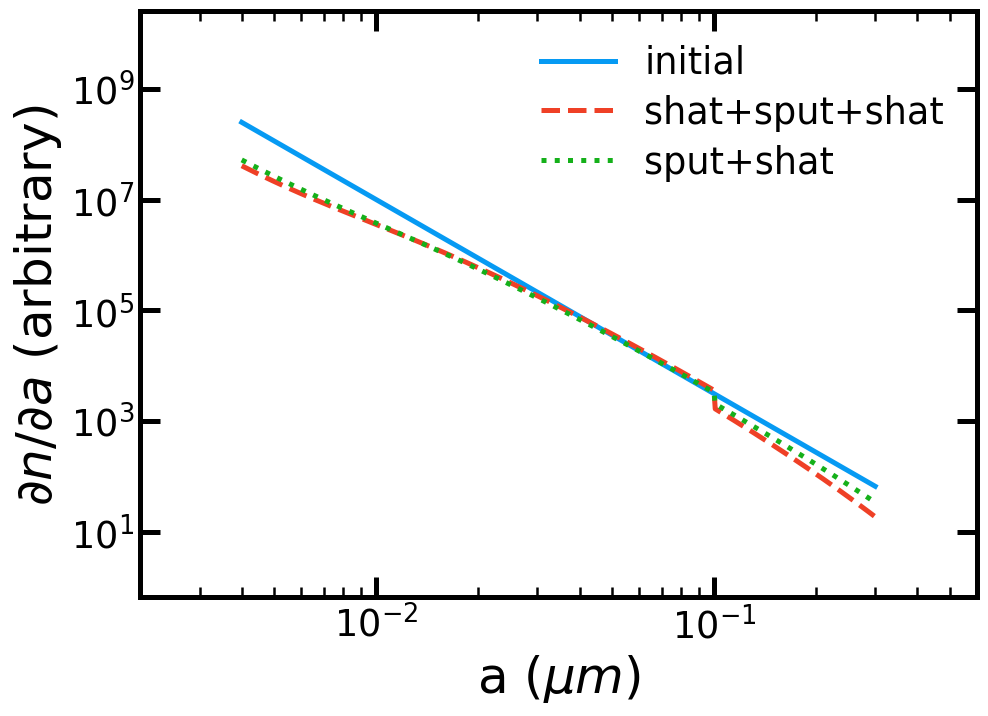

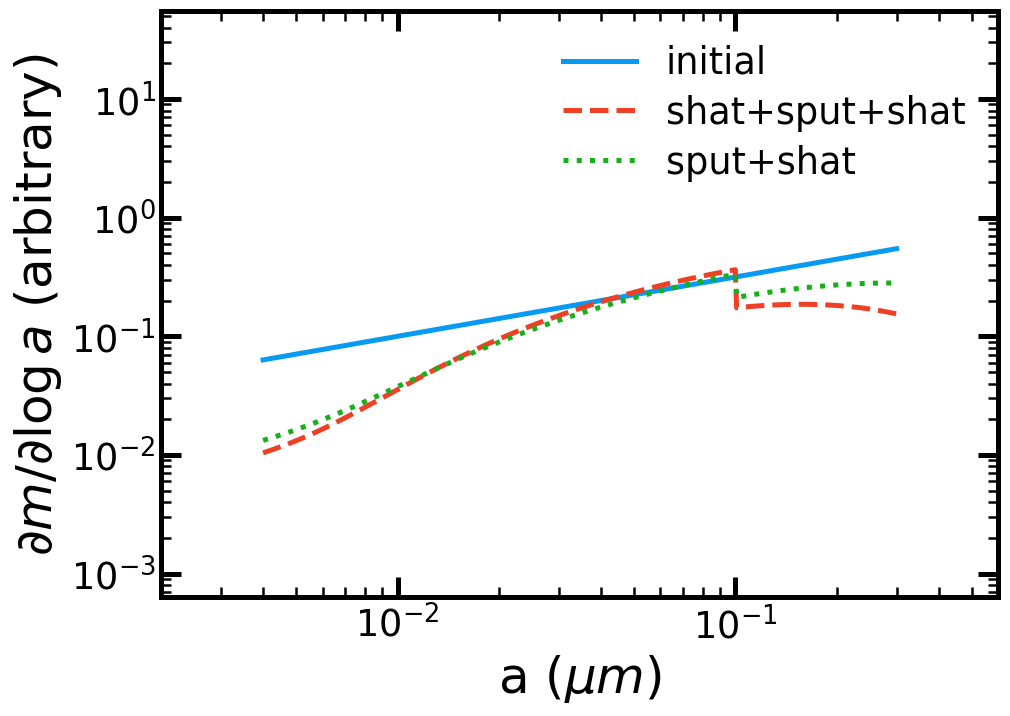

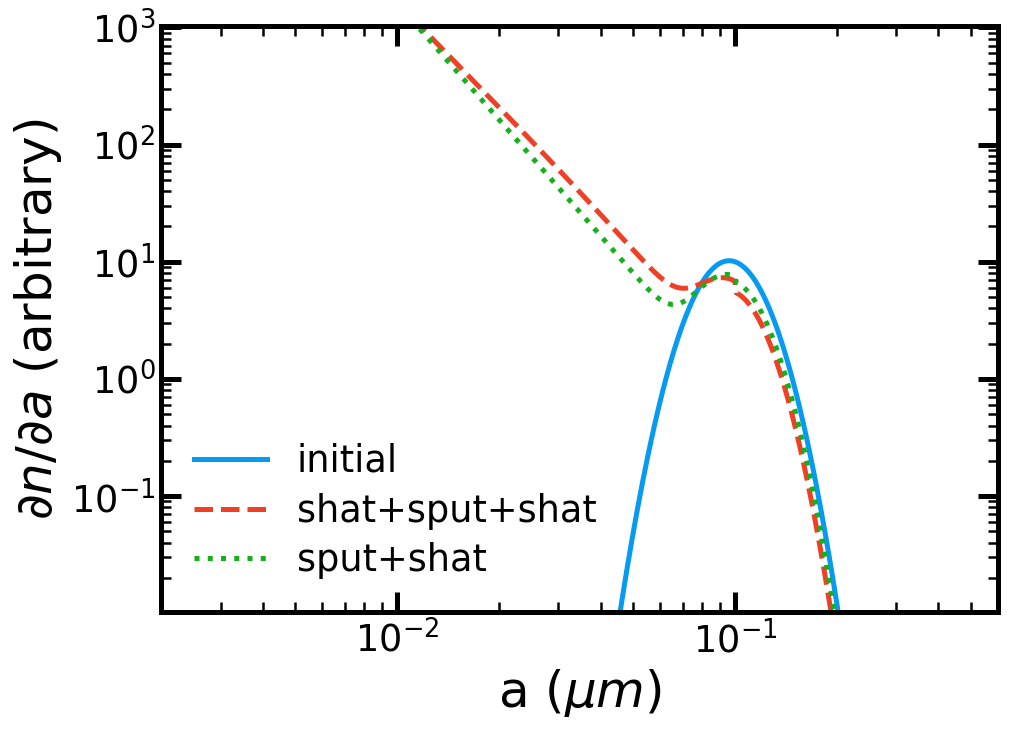

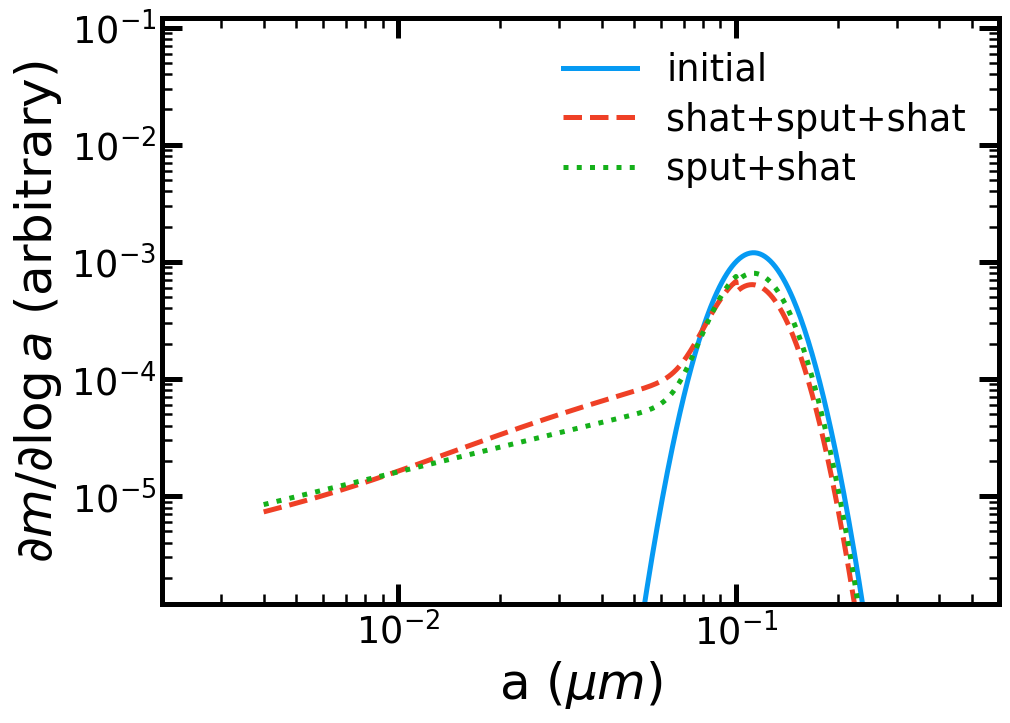

In [ ]:
# Set limits for size distribution
a_limit = [1E-3,5E0]
a_limit = [4E-3,0.3]

a = np.logspace(np.log10(a_limit[0]),np.log10(a_limit[1]),500)

a_sput = 0.1; # microns
a_shat = 0.1;
delta_sput = 0.2;
delta_shat = 0.2;
a_frag_max = a_shat

initial_dnda=MRN_dnda
initial_dmda=MRN_dmda

f_shspsh,dnda_shspsh,dmda_shspsh = shat_sput_shat(initial_dnda, initial_dmda, delta_sput,delta_shat, a_sput, a_shat, a_frag_max, a_limit)

f_spsh,dnda_spsh,dmda_spsh = sput_shat(initial_dnda, initial_dmda, delta_sput,delta_shat, a_sput, a_shat, a_frag_max, a_limit)

print("Initial MRN")
print("Sh+Sp+Sh Dest Frac:",f_shspsh)
print("Sp+Sh Dest Frac:",f_spsh)
y_limit = [np.min(initial_dnda(a))*1E-2,np.max(initial_dnda(a))*1E2]
x_limit=[a_limit[0]*0.5,a_limit[1]*2]
x_label = r'a ($\mu m$)'
y_label = r'$\partial n/\partial a$ (arbitrary)'
fig = Figure(1)
fig.set_axis(0, 'a', 'number_survival_frac', x_lim=x_limit, x_log=True, x_label=x_label, y_label=y_label, y_lim=y_limit, y_log=True)

i=0
fig.plot_line_data(0,a,initial_dnda(a),label='initial',color=colors[i], linestyle=linestyles[i])
i=1
fig.plot_line_data(0,a,dnda_shspsh(a),label='shat+sput+shat',color=colors[i], linestyle=linestyles[i])
i=2
fig.plot_line_data(0,a,dnda_spsh(a),label='sput+shat',color=colors[i], linestyle=linestyles[i])
fig.set_all_legends()


y_limit = [np.min(dmda(a)*a)*1E-2,np.max(dmda(a)*a)*1E2]
x_limit=[a_limit[0]*0.5,a_limit[1]*2]
y_label = r'$\partial m/\partial \log a$ (arbitrary)'
fig = Figure(1)
fig.set_axis(0, 'a', 'number_survival_frac', x_lim=x_limit, x_log=True, x_label=x_label, y_label=y_label, y_lim=y_limit, y_log=True)

i=0
fig.plot_line_data(0,a,initial_dmda(a)*a,label='initial',color=colors[i], linestyle=linestyles[i])
i=1
fig.plot_line_data(0,a,dmda_shspsh(a)*a,label='shat+sput+shat',color=colors[i], linestyle=linestyles[i])
i=2
fig.plot_line_data(0,a,dmda_spsh(a)*a,label='sput+shat',color=colors[i], linestyle=linestyles[i])

fig.set_all_legends()


initial_dnda=lognorm_dnda
initial_dmda=lognorm_dmda


f_shspsh,dnda_shspsh,dmda_shspsh = shat_sput_shat(initial_dnda, initial_dmda, delta_sput,delta_shat, a_sput, a_shat, a_frag_max, a_limit)

f_spsh,dnda_spsh,dmda_spsh = sput_shat(initial_dnda, initial_dmda, delta_sput,delta_shat, a_sput, a_shat, a_frag_max, a_limit)

print("Initial Lognorm")
print("Sh+Sp+Sh Dest Frac:",f_shspsh)
print("Sp+Sh Dest Frac:",f_spsh)

y_limit = [np.max(initial_dnda(a))*1E-3,np.max(initial_dnda(a))*1E2]
x_limit=[a_limit[0]*0.5,a_limit[1]*2]
y_label = r'$\partial n/\partial a$ (arbitrary)'
fig = Figure(1)
fig.set_axis(0, 'a', 'number_survival_frac', x_lim=x_limit, x_log=True, x_label=x_label, y_label=y_label, y_lim=y_limit, y_log=True)

i=0
fig.plot_line_data(0,a,initial_dnda(a),label='initial',color=colors[i], linestyle=linestyles[i])
i=1
fig.plot_line_data(0,a,dnda_shspsh(a),label='shat+sput+shat',color=colors[i], linestyle=linestyles[i])
i=2
fig.plot_line_data(0,a,dnda_spsh(a),label='sput+shat',color=colors[i], linestyle=linestyles[i])
fig.set_all_legends()


y_limit = [np.max(initial_dmda(a)*a)*1E-3,np.max(initial_dmda(a)*a)*1E2]
x_limit=[a_limit[0]*0.5,a_limit[1]*2]
y_label = r'$\partial m/\partial \log a$ (arbitrary)'
fig = Figure(1)
fig.set_axis(0, 'a', 'number_survival_frac', x_lim=x_limit, x_log=True, x_label=x_label, y_label=y_label, y_lim=y_limit, y_log=True)

i=0
fig.plot_line_data(0,a,initial_dmda(a)*a,label='initial',color=colors[i], linestyle=linestyles[i])
i=1
fig.plot_line_data(0,a,dmda_shspsh(a)*a,label='shat+sput+shat',color=colors[i], linestyle=linestyles[i])
i=2
fig.plot_line_data(0,a,dmda_spsh(a)*a,label='sput+shat',color=colors[i], linestyle=linestyles[i])

fig.set_all_legends()

### Comparing SNe grain size destruction models

Read in conversion table from Nozawa+07.

In [ ]:

from astropy.table import Table


def Nozawa_prescription(init_dnda, init_dmda, a_limit, smooth=True):
    Nozawa_table = Table.read('Nozawa_nH1.dat',format='ascii')
    ac_init = np.unique(Nozawa_table['a_init (cm)'].data)*1E4
    a1 = (Nozawa_table['a_init (cm)'].data)*1E4
    a2 = (Nozawa_table['a_final (cm)'].data)*1E4
    frac_i_to_f = Nozawa_table['Mg2SiO4'].data
    # Slight rounding errors in the Nozawa table means you can miss the a limit boundaries so extended them slightly
    ac_init = ac_init[(ac_init>=a_limit[0]*0.9) & (ac_init<=a_limit[1]*1.1)]
    ac_final = np.copy(ac_init)
    a_binwidth = 0.1 # dex

    
    # Check how many grains in each in bin move to other bins
    after_N_bin = np.zeros(len(ac_init))
    for i,ac in enumerate(ac_init):
        if i==0:
            bin_limits = [a_limit[0],np.power(10,np.log10(a_limit[0])+(a_binwidth/2))]
        elif i == len(ac_init)-1:
            bin_limits = [np.power(10,np.log10(a_limit[1])-(a_binwidth/2)),a_limit[1]]
        else:
            bin_limits = [np.power(10,np.log10(ac)-(a_binwidth/2)),np.power(10,np.log10(ac)+(a_binwidth/2))]

        N_bin = quad(init_dnda,bin_limits[0],bin_limits[1])[0]
        total_frac = 0
        for j,af in enumerate(ac_final):
            if af > ac: continue
            frac = frac_i_to_f[(a1==ac) & (a2==af)][0]
            after_N_bin[j] += frac * N_bin
            total_frac+=frac
    
    after_dnda = np.zeros(len(after_N_bin))
    for i,ac in enumerate(ac_init):
        if i==0:
            bin_limits = [a_limit[0],np.power(10,np.log10(a_limit[0])+(a_binwidth/2))]
        elif i == len(ac_init)-1:
            bin_limits = [np.power(10,np.log10(a_limit[1])-(a_binwidth/2)),a_limit[1]]
        else:
            bin_limits = [np.power(10,np.log10(ac)-(a_binwidth/2)),np.power(10,np.log10(ac)+(a_binwidth/2))]
    
        after_dnda[i] = after_N_bin[i]/(bin_limits[1]-bin_limits[0])
    
    
    # Need to smooth out dnda since this can have sharp dips for whatever reason
    if smooth:
        for i,ac in enumerate(ac_init):
            if i==0 or i ==len(ac_init)-1:
                continue
            
            if after_dnda[i] < after_dnda[i-1] and after_dnda[i] < after_dnda[i+1]:
                after_dnda[i] = np.power(10,(np.log10(after_dnda[i-1]) + np.log10(after_dnda[i+1]))/2)

    dnda_Nozawa = CubicSpline(ac_init,after_dnda)
    dmda_Nozawa = CubicSpline(ac_init,after_dnda*ac_init*ac_init*ac_init)
    initial_mass = quad(init_dmda, a_limit[0], a_limit[1])[0]
    f_nozawa = 1-quad(dmda_Nozawa, a_limit[0], a_limit[1])[0]/initial_mass

    return f_nozawa, dnda_Nozawa, dmda_Nozawa



Initial MRN
Sh+Sp+Sh Dest Frac: 0.5215073837796005
Sp Only Dest Frac: 0.5838153887718791
Nozawa+06 Dest Frac: 0.5757851309562995


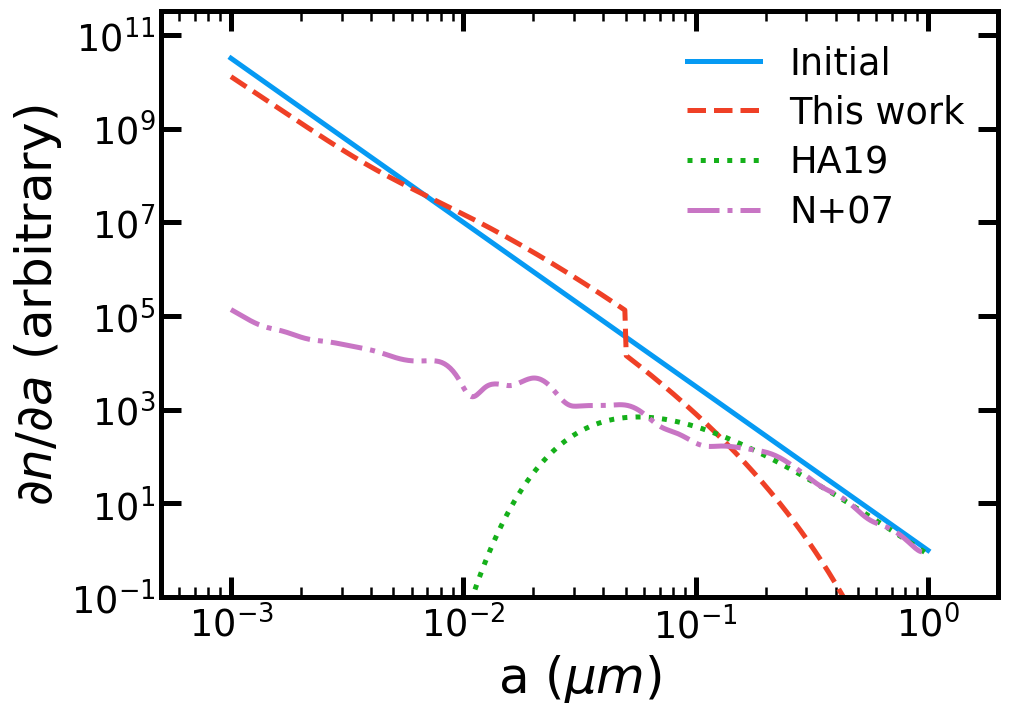

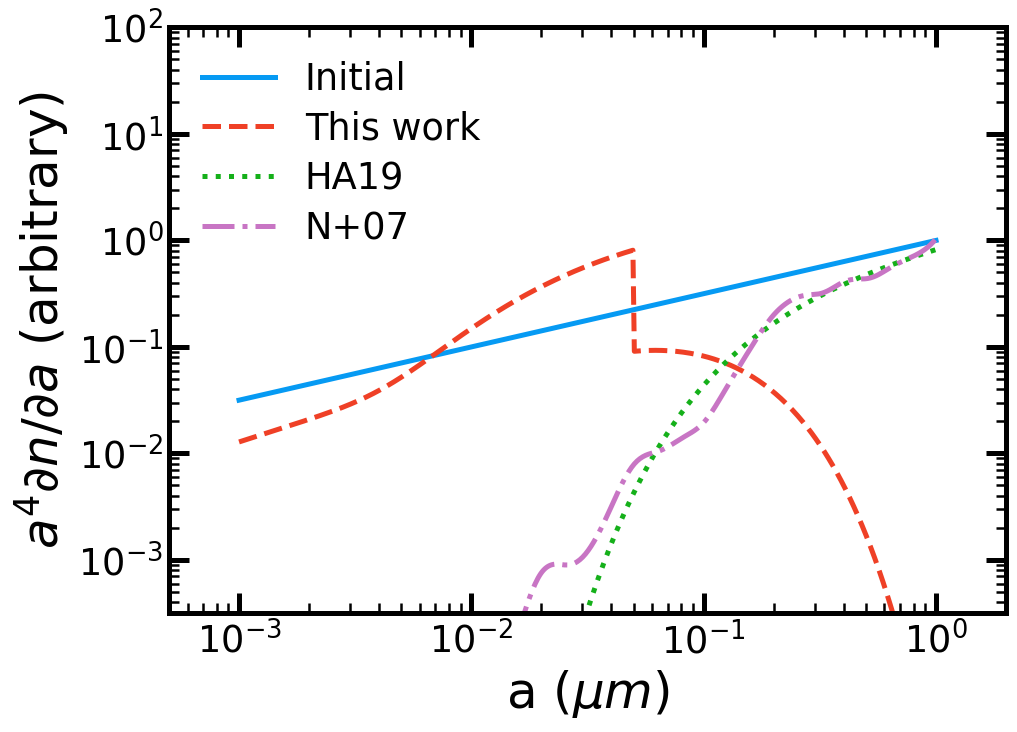

In [ ]:

color_N = 5
colors = config.LINE_COLORS[:color_N]
linestyles = config.LINE_STYLES[:color_N]
linewidths = config.LINE_WIDTHS[[0,color_N]]

# Set limits for size distribution
a_limit = [1E-3,1E0]
a = np.logspace(np.log10(a_limit[0]),np.log10(a_limit[1]),500)

a_sput = 0.05; # microns
a_shat = 0.05;
delta_sput = 0.3;
delta_shat = 0.3;
a_frag_max = a_shat

initial_dnda=MRN_dnda
initial_dmda=MRN_dmda

f_shspsh,dnda_shspsh,dmda_shspsh = shat_sput_shat(initial_dnda, initial_dmda, delta_sput,delta_shat, a_sput, a_shat, a_frag_max, a_limit)

f_sp,dnda_sp,dmda_sp = sput_only(initial_dnda, initial_dmda, 0.99, 0.2, a_limit)

f_noz,dnda_noz, dmda_noz = Nozawa_prescription(initial_dnda, initial_dmda,  a_limit)


print("Initial MRN")
print("Sh+Sp+Sh Dest Frac:",f_shspsh)
print("Sp Only Dest Frac:",f_sp)
print("Nozawa+06 Dest Frac:",f_noz)

y_limit = [np.min(initial_dnda(a))*1E-1,np.max(initial_dnda(a))*1E1]
x_limit=[a_limit[0]*0.5,a_limit[1]*2]
x_label = r'a ($\mu m$)'
y_label = r'$\partial n/\partial a$ (arbitrary)'
fig = Figure(1)
fig.set_axis(0, 'a', 'number_survival_frac', x_lim=x_limit, x_log=True, x_label=x_label, y_label=y_label, y_lim=y_limit, y_log=True)

i=0
fig.plot_line_data(0,a,initial_dnda(a),label='Initial',color=colors[i], linestyle=linestyles[i])
i=1
fig.plot_line_data(0,a,dnda_shspsh(a),label='This work',color=colors[i], linestyle=linestyles[i])
i=2
fig.plot_line_data(0,a,dnda_sp(a),label='HA19',color=colors[i], linestyle=linestyles[i])
i=3
fig.plot_line_data(0,a,dnda_noz(a),label='N+07',color=colors[i], linestyle=linestyles[i])
fig.set_all_legends()
fig.save(plot_dir+'MRN_dnda_SNe_comparison.pdf')

y_limit = [np.min(initial_dmda(a)*a)*1E-2,np.max(initial_dmda(a)*a)*1E2]
x_limit=[a_limit[0]*0.5,a_limit[1]*2]
y_label = r'$a^4 \partial n/\partial a$ (arbitrary)'
fig = Figure(1)
fig.set_axis(0, 'a', 'number_survival_frac', x_lim=x_limit, x_log=True, x_label=x_label, y_label=y_label, y_lim=y_limit, y_log=True)

i=0
fig.plot_line_data(0,a,initial_dmda(a)*a,label='Initial',color=colors[i], linestyle=linestyles[i])
i=1
fig.plot_line_data(0,a,dmda_shspsh(a)*a,label='This work',color=colors[i], linestyle=linestyles[i])
i=2
fig.plot_line_data(0,a,dmda_sp(a)*a,label='HA19',color=colors[i], linestyle=linestyles[i])
i=3
fig.plot_line_data(0,a,dmda_noz(a)*a,label='N+07',color=colors[i], linestyle=linestyles[i])
fig.set_all_legends()
fig.save(plot_dir+'MRN_dmda_SNe_comparison.pdf')

Initial MRN
Sh+Sp+Sh Dest Frac: 0.3546013626345138
Sp Only Dest Frac: 0.3322553895308493
Nozawa+06 Dest Frac: 0.9644677621329625


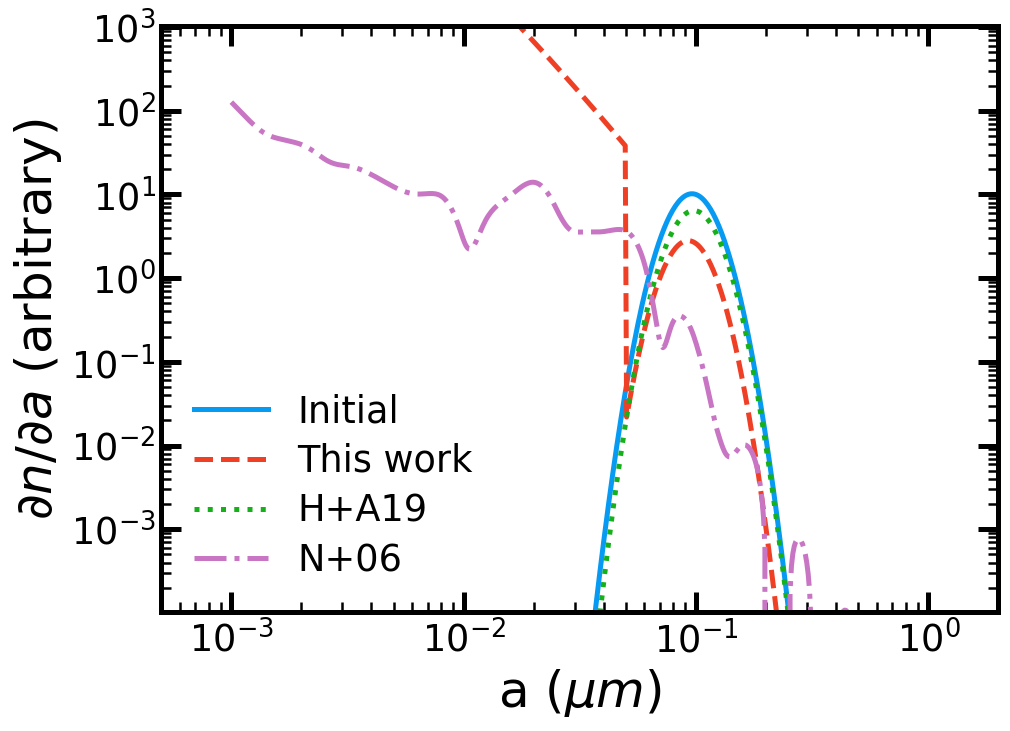

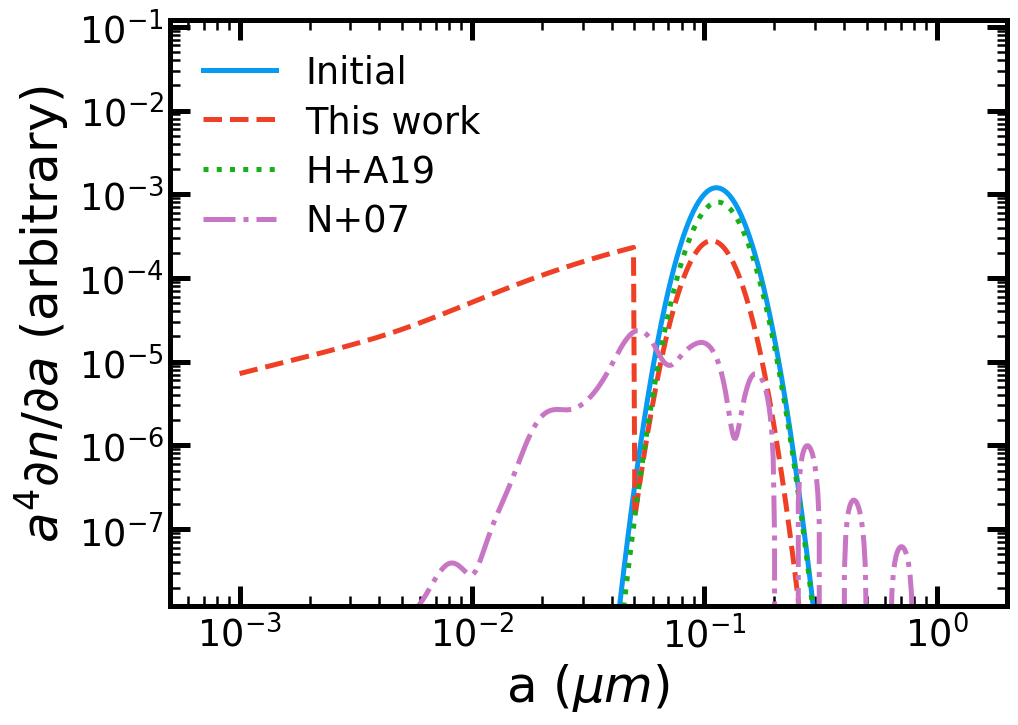

In [ ]:
color_N = 5
colors = config.LINE_COLORS[:color_N]
linestyles = config.LINE_STYLES[:color_N]
linewidths = config.LINE_WIDTHS[[0,color_N]]

# Set limits for size distribution
a_limit = [1E-3,1E0]

a = np.logspace(np.log10(a_limit[0]),np.log10(a_limit[1]),500)

a_sput = 0.05; # microns
a_shat = 0.05;
delta_sput = 0.3;
delta_shat = 0.3;
a_frag_max = a_shat

initial_dnda=lognorm_dnda
initial_dmda=lognorm_dmda

f_shspsh,dnda_shspsh,dmda_shspsh = shat_sput_shat(initial_dnda, initial_dmda, delta_sput,delta_shat, a_sput, a_shat, a_frag_max, a_limit)

f_sp,dnda_sp,dmda_sp = sput_only(initial_dnda, initial_dmda, 0.9, a_sput, a_limit)

f_noz,dnda_noz, dmda_noz = Nozawa_prescription(initial_dnda, initial_dmda,  a_limit)


print("Initial MRN")
print("Sh+Sp+Sh Dest Frac:",f_shspsh)
print("Sp Only Dest Frac:",f_sp)
print("Nozawa+06 Dest Frac:",f_noz)

y_limit = [np.max(initial_dnda(a))*1E-5,np.max(initial_dnda(a))*1E2]
x_limit=[a_limit[0]*0.5,a_limit[1]*2]
x_label = r'a ($\mu m$)'
y_label = r'$\partial n/\partial a$ (arbitrary)'
fig = Figure(1)
fig.set_axis(0, 'a', 'number_survival_frac', x_lim=x_limit, x_log=True, x_label=x_label, y_label=y_label, y_lim=y_limit, y_log=True)

i=0
fig.plot_line_data(0,a,initial_dnda(a),label='Initial',color=colors[i], linestyle=linestyles[i])
i=1
fig.plot_line_data(0,a,dnda_shspsh(a),label='This work',color=colors[i], linestyle=linestyles[i])
i=2
fig.plot_line_data(0,a,dnda_sp(a),label='H+A19',color=colors[i], linestyle=linestyles[i])
i=3
fig.plot_line_data(0,a,dnda_noz(a),label='N+06',color=colors[i], linestyle=linestyles[i])
fig.set_all_legends()
fig.save(plot_dir+'lognorm_dnda_SNe_comparison.pdf')

y_limit = [np.max(initial_dmda(a)*a)*1E-5,np.max(initial_dmda(a)*a)*1E2]
x_limit=[a_limit[0]*0.5,a_limit[1]*2]
y_label = r'$a^4 \partial n/\partial a$ (arbitrary)'
fig = Figure(1)
fig.set_axis(0, 'a', 'number_survival_frac', x_lim=x_limit, x_log=True, x_label=x_label, y_label=y_label, y_lim=y_limit, y_log=True)

i=0
fig.plot_line_data(0,a,initial_dmda(a)*a,label='Initial',color=colors[i], linestyle=linestyles[i])
i=1
fig.plot_line_data(0,a,dmda_shspsh(a)*a,label='This work',color=colors[i], linestyle=linestyles[i])
i=2
fig.plot_line_data(0,a,dmda_sp(a)*a,label='H+A19',color=colors[i], linestyle=linestyles[i])
i=3
fig.plot_line_data(0,a,dmda_noz(a)*a,label='N+07',color=colors[i], linestyle=linestyles[i])
fig.set_all_legends()
fig.save(plot_dir+'lognorm_dmda_SNe_comparison.pdf')